In [ ]:
import os
import pandas as pd
import datetime 
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from functools import reduce
from pingouin import cronbach_alpha
from tqdm import tqdm
from numba import njit

from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

## Loading raw datasets

In [3]:
# Path to the folder where the CSVs are downloaded
download_dir = '/Users/rachelrobles/Documents/Coding_projects/Thesis'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(download_dir) if f.endswith('.csv')]

# Dictionary to store DataFrames dynamically based on file name
dataframes_dict = {}

# Loop through all CSV files and load them into DataFrames
for file_name in csv_files:
    file_path = os.path.join(download_dir, file_name)
    
    # Load the CSV into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Save the DataFrame to the dictionary using the file name (without extension) as the key
    file_name_without_ext = os.path.splitext(file_name)[0]  # Remove the file extension
    dataframes_dict[file_name_without_ext] = df

/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_94323/2333746059.py:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_94323/2333746059.py:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_94323/2333746059.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_94323/2333746059.py:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [4]:
for key, value in dataframes_dict.items():
    print(f"{key}")

study_003_1_plrc_fitzgerald__eligible_users-000000000000
fact_001_app__observations-000000000007
fact_001_app__observations-000000000013
dim_008_lookups__health_variable_classification-000000000000
fact_001_app__observations-000000000012
fact_001_app__observations-000000000006
fact_001_app__observations-000000000010
fact_001_app__observations-000000000004
fact_001_app__observations-000000000005
fact_001_app__observations-000000000011
fact_001_app__observations-000000000015
fact_001_app__observations-000000000001
dim_007_lookups__health_variables-000000000000
fact_001_app__observations-000000000000
fact_001_app__observations-000000000014
fact_001_app__observations-000000000002
fact_001_app__observations-000000000016
fact_001_app__observations-000000000017
fact_001_app__observations-000000000003
dim_002_userinfo__user_illness-000000000000
dim_009_lookups__rating_scale-000000000000
study_003_1_plrc_fitzgerald__survey_responses-000000000000
dim_001_userinfo__user-000000000000
dim_010_looku

### Study enrollment

In [5]:
# Load and filter PLRC study participants
plrc_study_participants = (
    dataframes_dict["study_003_1_plrc_fitzgerald__eligible_users-000000000000"] # Dataset of people enrolled in PLRC study as of query date
    .query("eligible == True and withdrawn == False") # Only include people who are eligible and who have not withdrawn
    .drop(columns=['study_id_pk', 'eligible', 'withdrawn', 'withdrawn_date'])
    .rename(columns={'completed_date': 'study_enrollment_date'})
)

# Convert to datetime
plrc_study_participants['study_enrollment_date'] = pd.to_datetime(plrc_study_participants['study_enrollment_date'])

print(f"# of entries: {len(plrc_study_participants)} and # of current participants: {plrc_study_participants['user_id_pk'].nunique()}")

plrc_study_participants.head(2)

# of entries: 9632 and # of current participants: 9632


,user_id_pk,study_enrollment_date
0,10,2024-04-22
1,11,2024-04-25


In [6]:
# Load and reshape survey responses 
plrc_survey = dataframes_dict["study_003_1_plrc_fitzgerald__survey_responses-000000000000"] # Dataset of people enrolled in PLRC study as of query date

# Pivot and rename relevant columns
pivot_plrc_survey = (
    plrc_survey.pivot(index="user_id_pk", columns="question_id_pk", values="answer")
    .rename(columns={
        1: 'long_covid_at_enrollment',
        2: 'number_cov_inf_at_enrollment'
    })
    .drop(columns=[col for col in [4, 5, 6, 7, 8] if col in plrc_survey['question_id_pk'].unique()], errors='ignore')
    .reset_index()
)

# Ensure correct data types
pivot_plrc_survey = pivot_plrc_survey.astype({
    'long_covid_at_enrollment': 'Int64',
    'number_cov_inf_at_enrollment': 'Int64'
})

print(f"Number of users who completed the survey as of 04/10/2025: {pivot_plrc_survey['user_id_pk'].nunique()}")

pivot_plrc_survey.head(2)

Number of users who completed the survey as of 04/10/2025: 9722


question_id_pk,user_id_pk,long_covid_at_enrollment,number_cov_inf_at_enrollment
0,10,1,1
1,11,1,1


In [7]:
# --- Merge participant info with survey data ---
plrc_df = plrc_study_participants.merge(pivot_plrc_survey, on='user_id_pk', how='left')

print(f"# of entries: {len(plrc_df)} and # of current participants: {plrc_df['user_id_pk'].nunique()}")

plrc_df.head(2)

# of entries: 9632 and # of current participants: 9632


,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment
0,10,2024-04-22,1,1
1,11,2024-04-25,1,1


### Fact tables

In [8]:
# Combine all 'fact'-related DataFrames 
combined_fact_df = (
    pd.concat(
        [df for name, df in dataframes_dict.items() if 'fact' in name],
        ignore_index=True
    )
    .drop(columns=[
        'created_at', 'updated_at', 'row_id', 
        'observation_descriptor', 'rating_scale_value_id'  # dropping rating scale value and observation descriptor because these columns are deprecated 
    ])
    .rename(columns={'quality': 'quality_of_reading'})
)
print(f"Initial fact dataframe:")
print(f" - # of participants: {combined_fact_df['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_fact_df)}")
print(f" - # of unique user-date-variable entries: {combined_fact_df[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")

Initial fact dataframe:
 - # of participants: 9704
 - # of entries: 76472291
 - # of unique user-date-variable entries: 76472291


In [9]:
# Handle data issue: infection (id=63) = 0 → set infection source (id=64) to NaN
# Identify (user, date) pairs where infection = 0 or NaN
infected_zero_pairs = (
    combined_fact_df
    .query("health_variable_id_pk == 63 and (observation_value == 0 | observation_value.isna())")
    [['user_id_pk', 'observation_date_pk']]
    .drop_duplicates()
    .assign(flag=True)
)

# Merge flag into main df and apply correction
combined_fact_df = (
    combined_fact_df
    .merge(infected_zero_pairs, on=['user_id_pk', 'observation_date_pk'], how='left')
)

# Set observation_value to NaN where health_variable_id_pk == 64 and infection = 0 for that day
combined_fact_df.loc[
    (combined_fact_df['health_variable_id_pk'] == 64) & (combined_fact_df['flag'] == True),
    'observation_value'
] = np.nan

# Drop helper column
combined_fact_df.drop(columns='flag', inplace=True)

# Filter for active PLRC study participants only
combined_fact_df = combined_fact_df[combined_fact_df['user_id_pk'].isin(plrc_df['user_id_pk'])]

print(f"After filtering for active participants:")
print(f" - # of participants: {combined_fact_df['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_fact_df)}")
print(f" - # of unique user-date-variable entries: {combined_fact_df[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")

# Final cleanup
combined_fact_df['observation_date_pk'] = pd.to_datetime(combined_fact_df['observation_date_pk'])

combined_fact_df.head(2)

After filtering for active participants:
 - # of participants: 9626
 - # of entries: 76053745
 - # of unique user-date-variable entries: 76053745


,user_id_pk,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading
0,21562,2024-05-17,49,0.0,NaN
1,21562,2024-05-17,60,0.0,NaN


### User demographics

In [10]:
# Create dataframe from data set
user_info = dataframes_dict["dim_001_userinfo__user-000000000000"]

# Create age field that better represents year_of_birth
user_info['age'] = pd.to_datetime(user_info['updated_at']).dt.year - user_info['year_of_birth']
user_info = user_info.drop(['created_at', 'updated_at', 'year_of_birth'], axis=1)

print(f"# of entries: {len(user_info)} and # of user entries: {user_info['user_id_pk'].nunique()}")
user_info.head(2)

# of entries: 9722 and # of user entries: 9722


,user_id_pk,gender_id,gender_description,disabled,age
0,10,2,NaN,False,42
1,11,2,NaN,False,53


In [11]:
# Create dataframe from data set
user_illness = dataframes_dict["dim_002_userinfo__user_illness-000000000000"]
user_illness = user_illness.sort_values(['updated_at'], ascending = False).drop_duplicates('user_id_pk').drop(['created_at', 'updated_at', 'row_id'], axis=1) 
# sorting and dropping duplicates for anyone who modified their data

print(f"# of entries: {len(user_illness)} and # of user entries: {user_illness['user_id_pk'].nunique()}")
user_illness.head(2)

# of entries: 9716 and # of user entries: 9716


,user_id_pk,long_covid,me_cfs,other_illness
9443,166535,False,True,"Adhd, raynauds, sicca, hypermobile"
9019,151249,False,True,"Cytomegalovirus, PCOS"


In [12]:
# Create dataframe from data set
genders = dataframes_dict["dim_006_lookups__gender-000000000000"]
genders = genders.drop(['created_at', 'updated_at'], axis=1)

genders.head(2)

,gender_id_pk,gender_name
0,1,Man
1,2,Woman


In [13]:
# Create user demographics dataframe 
user_demographics = user_info.merge(user_illness, how='outer', on='user_id_pk').merge(genders, how='left', left_on='gender_id', right_on='gender_id_pk').drop('gender_id_pk', axis=1)
user_demographics = user_demographics[['user_id_pk', 'age', 'gender_id', 'gender_name', 'gender_description', 'disabled', 'long_covid', 'me_cfs', 'other_illness']]

print(f"# of entries: {len(user_demographics)} and # of user entries: {user_demographics['user_id_pk'].nunique()}")
user_demographics.head(2)

# of entries: 9722 and # of user entries: 9722


,user_id_pk,age,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness
0,10,42,2,Woman,NaN,False,True,True,NaN
1,11,53,2,Woman,NaN,False,True,True,POTS


### Health variables

In [14]:
# Create dataframe from data set
health_variables = dataframes_dict["dim_007_lookups__health_variables-000000000000"]
health_variables = health_variables.drop(['created_at', 'updated_at', 'user_id'], axis=1).rename({'is_published':'published_health_variable'}, axis=1)
health_variables['health_variable_name'] = health_variables['health_variable_name'].str.lower().str.strip()
health_variables['health_variable_name'] = health_variables['health_variable_name'].str.replace(r'[#,@,&,().]', '', regex=True)
health_variables['health_variable_name'] = health_variables['health_variable_name'].str.replace(r'[\\/\\-]', '_', regex=True)
health_variables['health_variable_name'] = health_variables['health_variable_name'].str.replace(' ', '_')

# Filtering for only health variables used in our data 
health_variables = health_variables[health_variables['health_variable_id_pk'].isin(combined_fact_df['health_variable_id_pk'])]

print(f"# of entries: {len(health_variables)} and # of health variables: {health_variables['health_variable_id_pk'].nunique()}")
health_variables.head(2)

# of entries: 45675 and # of health variables: 45675


,health_variable_id_pk,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable
0,3,fatigue,"How was your fatigue today, at its worst?",1.0,1,True
1,4,palpitations,"How were your palpitations today, at their worst?",1.0,3,True


In [15]:
health_variable_classification = dataframes_dict["dim_008_lookups__health_variable_classification-000000000000"]
health_variable_classification = health_variable_classification.drop(['created_at', 'updated_at'], axis=1)

print(f"# of entries: {len(health_variable_classification)} and # of health variable classifications: {health_variable_classification['health_variable_classification_id_pk'].nunique()}")
health_variable_classification.head(2)

# of entries: 27 and # of health variable classifications: 27


,health_variable_classification_id_pk,health_variable_category,health_variable_type
0,1,General,Symptom
1,2,Brain,Symptom


In [16]:
ratings = dataframes_dict["dim_009_lookups__rating_scale-000000000000"]
ratings = ratings.drop(['created_at', 'updated_at'], axis=1)

ratings.head(2)

,rating_scale_id_pk,rating_scale_name
0,1,Severity
1,2,Extremity


In [17]:
ratings_values = dataframes_dict["dim_010_lookups__rating_scale_values-000000000000"]
ratings_values = ratings_values.drop(['created_at', 'updated_at', 'row_id'], axis=1)

ratings_values.head(2)

,rating_scale_id_pk,rating_scale_value_pk,rating_scale_descriptor
0,1,0,NaN
1,2,0,NaN


In [18]:
ratings_df = ratings.merge(ratings_values, how='outer', on='rating_scale_id_pk')

print(f"# of entries: {len(ratings_df)} and # of rating scale value pairs: {len(ratings_df[['rating_scale_id_pk', 'rating_scale_value_pk']].drop_duplicates())}")
ratings_df.head(2)

# of entries: 24 and # of rating scale value pairs: 24


,rating_scale_id_pk,rating_scale_name,rating_scale_value_pk,rating_scale_descriptor
0,1,Severity,0,NaN
1,1,Severity,1,Mild


#### Create dataframe

In [19]:
health_variable_df = health_variables.merge(
    health_variable_classification, how='left', left_on='health_variable_classification_id', right_on='health_variable_classification_id_pk').merge(
        ratings_df, how='left', left_on='rating_scale_id', right_on='rating_scale_id_pk').drop(['health_variable_classification_id_pk', 'rating_scale_id_pk'], axis=1)

print(f"# of entries: {len(health_variable_df)} and # of health variable value pairs: {len(health_variable_df[['health_variable_id_pk', 'rating_scale_value_pk']].drop_duplicates())}")
health_variable_df.head(2)

# of entries: 134445 and # of health variable value pairs: 134445


,health_variable_id_pk,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_value_pk,rating_scale_descriptor
0,3,fatigue,"How was your fatigue today, at its worst?",1.0,1,True,General,Symptom,Severity,0.0,NaN
1,3,fatigue,"How was your fatigue today, at its worst?",1.0,1,True,General,Symptom,Severity,1.0,Mild


In [20]:
print('health_variable_df columns: ', health_variable_df.columns)

health_variable_df columns:  Index(['health_variable_id_pk', 'health_variable_name',
       'health_variable_question', 'rating_scale_id',
       'health_variable_classification_id', 'published_health_variable',
       'health_variable_category', 'health_variable_type', 'rating_scale_name',
       'rating_scale_value_pk', 'rating_scale_descriptor'],
      dtype='object')


## Preparing data

### Merge datasets

In [21]:
# Create dataframes for population with valid ratings - health variables supplied by Visible
health_vars_pub = health_variable_df[(health_variable_df['published_health_variable']==True)]
health_vars_custom = health_variable_df[(health_variable_df['health_variable_classification_id']==15)]
health_vars_w_ratings = pd.concat([health_vars_pub[health_vars_pub['health_variable_type']!="Biometric"], health_vars_custom])

# Create biometric data set that can be merged separately because it has no rating values
health_vars_biometrics = health_variable_df[health_variable_df['health_variable_type']=="Biometric"].dropna(axis=1)
health_vars_biometrics.rename({'health_variable_name':'health_variable_name_ins', 'health_variable_classification_id':'health_variable_classification_id_ins', 
                     'published_health_variable':'published_health_variable_ins', 'health_variable_category':'health_variable_category_ins', 
                     'health_variable_type':'health_variable_type_ins'}, axis=1, inplace=True)

print(f"# of entries: {len(health_vars_w_ratings)} and # of health variable value pairs: {len(health_vars_w_ratings[['health_variable_id_pk', 'rating_scale_value_pk']].drop_duplicates())}")
print(f"# of entries: {len(health_vars_biometrics)} and # of health variable value pairs: {len(health_vars_biometrics[['health_variable_id_pk']].drop_duplicates())}")

# of entries: 86130 and # of health variable value pairs: 86130
# of entries: 7 and # of health variable value pairs: 7


In [22]:
# Merge dataframes together for full dataset
combined_df = plrc_df.merge(combined_fact_df, how='left', on='user_id_pk')
combined_df = combined_df.merge(user_demographics, how='left', on='user_id_pk')
combined_df = combined_df.merge(
     health_vars_w_ratings, how='left', left_on=['health_variable_id_pk', 'observation_value'], right_on=['health_variable_id_pk', 'rating_scale_value_pk']).drop(
         ['rating_scale_value_pk'], axis=1)
combined_df = combined_df.merge(health_vars_biometrics, how='left', on='health_variable_id_pk')

# Combine long covid y/n columns to say the person had long covid if they ever responded yes in the app
combined_df['long_covid'] = ((combined_df['long_covid'] == True) | (combined_df['long_covid_at_enrollment'] == 1)).astype(int)

# Combine column values and delete excess columns
columns_to_fill = [
    'health_variable_name',
    'health_variable_classification_id',
    'published_health_variable',
    'health_variable_category',
    'health_variable_type'
]

for col in columns_to_fill:
    combined_df[col] = combined_df[col].fillna(combined_df[f"{col}_ins"])

# Drop the *_ins columns after merging
combined_df.drop([f"{col}_ins" for col in columns_to_fill], axis=1, inplace=True)

print(f"Counts for initial dataset:")
print(f" - # of participants: {combined_df['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_df)}")
print(f" - # of unique user-date-variable entries: {combined_df[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")

combined_df.head(2)

Counts for initial dataset:
 - # of participants: 9632
 - # of entries: 76053751
 - # of unique user-date-variable entries: 76053751


,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading,age,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_descriptor
0,10,2024-04-22,1,1,2022-08-30,47.0,1.0,NaN,42,2,Woman,NaN,False,1,True,NaN,sleep,How did you sleep?,3.0,11.0,True,Sleep,Sleep,Quality,Fair
1,10,2024-04-22,1,1,2022-08-30,54.0,65.0,NaN,42,2,Woman,NaN,False,1,True,NaN,resting_hr,NaN,NaN,16.0,True,Measurement,Biometric,NaN,NaN


### Create infection-related dataset

In [23]:
# Pivot the infection data
infection_df = combined_df.query("health_variable_id_pk == 63 | health_variable_id_pk == 64").copy()
infection_pivot_df = (
    infection_df.pivot(index=['user_id_pk',  'study_enrollment_date', 'number_cov_inf_at_enrollment', 'observation_date_pk'], 
                       columns='health_variable_id_pk', values='observation_value')
    .reset_index()
    .rename(columns={63: 'infection', 64: 'infection_source'})
)

# Separate out infection and infection source columns into binary fields
infection_pivot_df['active_covid_infection'] = np.where(infection_pivot_df['infection']==1, np.where((infection_pivot_df['infection_source'].isin([0, 1])),1,0), 0)
infection_pivot_df['active_other_infection'] = np.where(infection_pivot_df['infection']==1, np.where((infection_pivot_df['infection_source']==2),1,0), 0)
infection_pivot_df['active_unknown_infection'] = np.where(infection_pivot_df['infection']==1, np.where((infection_pivot_df['infection_source'].isna()),1,0), 0)
infection_pivot_df = infection_pivot_df.drop(columns=['infection', 'infection_source'])

# Create MultiIndex of all user-date pairs to ensure that we account for days when a user did not log an infection but they logged other health variables
all_users = infection_pivot_df['user_id_pk'].unique()
full_dates = pd.date_range(combined_df['observation_date_pk'].min(), combined_df['observation_date_pk'].max())
full_index = pd.MultiIndex.from_product(
    [all_users, full_dates],
    names=['user_id_pk', 'observation_date_pk']
)
infection_pivot_df = infection_pivot_df.set_index(['user_id_pk', 'observation_date_pk'])
infection_pivot_df = infection_pivot_df.reindex(full_index).reset_index()

# Fill NAs
infection_pivot_df = infection_pivot_df.fillna({'active_covid_infection':0, 'active_other_infection':0, 'active_unknown_infection':0}) # Fill NaNs with 0 for binary columns
infection_pivot_df['study_enrollment_date'] = infection_pivot_df.groupby('user_id_pk')['study_enrollment_date'].transform('first')
infection_pivot_df['number_cov_inf_at_enrollment'] = infection_pivot_df.groupby('user_id_pk')['number_cov_inf_at_enrollment'].transform('first')

print(f"After creating user-date infection dataframe:")
print(f" - # of participants: {infection_pivot_df['user_id_pk'].nunique()}")
print(f" - # of entries: {len(infection_pivot_df)}")
print(f" - # of unique user-date entries: {infection_pivot_df[['user_id_pk', 'observation_date_pk']].drop_duplicates().shape[0]}")

infection_pivot_df.head(2)

After creating user-date infection dataframe:
 - # of participants: 8638
 - # of entries: 8249290
 - # of unique user-date entries: 8249290


health_variable_id_pk,user_id_pk,observation_date_pk,study_enrollment_date,number_cov_inf_at_enrollment,active_covid_infection,active_other_infection,active_unknown_infection
0,11,2022-08-30,2024-04-25,1,0.0,0.0,0.0
1,11,2022-08-31,2024-04-25,1,0.0,0.0,0.0


In [24]:
def clean_infection_starts(df, infection_col, cooldown_days, output_col):
    """
    Marks distinct infection starts (1) per user, with a cooldown period to avoid counting duplicates.
    Assumes sparse logging is possible (i.e., skips are allowed).

    Parameters:
    - df (DataFrame): Input DataFrame containing user infection observations over time.
    - infection_col (str): Name of the column indicating active infection (e.g., binary 0/1).
    - cooldown_days (int): Number of days that must pass before a new infection can be logged.
    - output_col (str): Name of the output column that will be created to mark infection starts (1 if start, 0 otherwise).
    """

    df = df.sort_values(['user_id_pk', 'observation_date_pk']).copy()
    df['date_int'] = df['observation_date_pk'].astype(np.int64) // 10**9  # seconds since epoch

    # Preprocess group index arrays (as list of lists for Numba)
    user_id_to_indices = defaultdict(list)
    for i, user_id in enumerate(df['user_id_pk'].values):
        user_id_to_indices[user_id].append(i)

    user_groups = list(user_id_to_indices.values())  # list of lists of indices

    @njit
    def compute_starts(date_ints, infection_flags, user_groups, cooldown_days):
        output = np.zeros(len(date_ints), dtype=np.uint8)

        for group in user_groups:
            last_start = -1e12  # far in the past

            for i in group:
                if infection_flags[i] == 1:
                    if date_ints[i] - last_start >= cooldown_days * 86400:
                        output[i] = 1
                        last_start = date_ints[i]

        return output

    # Prepare arrays
    date_array = df['date_int'].values
    infection_array = df[infection_col].values.astype(np.uint8)
    user_group_array = [np.array(g, dtype=np.int64) for g in user_groups]

    # Run Numba-compiled function
    starts = compute_starts(date_array, infection_array, user_group_array, cooldown_days)

    # Assign to df
    df[output_col] = starts
    df.drop(columns=['date_int'], inplace=True)

    return df

In [25]:
infection_df = infection_pivot_df.copy()

# Create "infection start" flags by looking for the beginning of an infection streak
infection_df = clean_infection_starts(infection_df, infection_col='active_covid_infection', cooldown_days=60, output_col='beg_of_covid_infection')
infection_df = clean_infection_starts(infection_df, infection_col='active_other_infection', cooldown_days=30, output_col='beg_of_other_infection')
infection_df = clean_infection_starts(infection_df, infection_col='active_unknown_infection', cooldown_days=30, output_col='beg_of_unknown_infection')

infection_df.head(2)

health_variable_id_pk,user_id_pk,observation_date_pk,study_enrollment_date,number_cov_inf_at_enrollment,active_covid_infection,active_other_infection,active_unknown_infection,beg_of_covid_infection,beg_of_other_infection,beg_of_unknown_infection
0,11,2022-08-30,2024-04-25,1,0.0,0.0,0.0,0,0,0
1,11,2022-08-31,2024-04-25,1,0.0,0.0,0.0,0,0,0


In [26]:
def compute_cumulative_covid_infections(df):
    """
    Computes the cumulative number of Covid-19 infections for each user over time,
    accounting for infections logged before and after study enrollment.

    Logic:
    - For dates before study enrollment, infections are retroactively assigned based on the baseline count at enrollment
      and any `beg_of_covid_infection` markers found before the enrollment date.
    - For dates after enrollment, the count increases whenever a new infection is logged (`beg_of_covid_infection == 1.0`).

    Parameters:
    - df (DataFrame): Input DataFrame with the following required columns:
        - 'user_id_pk': unique user identifier
        - 'observation_date_pk': observation date
        - 'study_enrollment_date': date user joined the study
        - 'number_cov_inf_at_enrollment': baseline number of infections at enrollment
        - 'beg_of_covid_infection': 1.0 if an infection start is marked on that date, else 0

    Returns:
    - DataFrame with an added column `num_covid_infections` representing the cumulative infection count for each user over time.
    """

    df['num_covid_infections'] = np.nan # Initialize output column

    for user_id, group in df.groupby('user_id_pk'):
        group = group.sort_values('observation_date_pk').copy()

        # Retrieve baseline data
        enrollment_date = pd.to_datetime(group['study_enrollment_date'].iloc[0])
        baseline_count = int(group['number_cov_inf_at_enrollment'].iloc[0])

        # Create post enrollment
        post_enroll = group[group['observation_date_pk'] >= enrollment_date]

        ### PRE-ENROLLMENT LOGIC ###
        # Identify retroactively logged infections before enrollment
        logged_infections = group.loc[
            (group['observation_date_pk'] < enrollment_date) & (group['beg_of_covid_infection'] == 1.0),
            'observation_date_pk'
        ].sort_values(ascending=False).tolist() # Most recent first

        for j, inf_date in enumerate(logged_infections):
            count = baseline_count - j # Back-calculate infection count
            group.loc[group['observation_date_pk'] == inf_date, 'num_covid_infections'] = count

            # Fill in count for dates between this and next infection
            next_date = enrollment_date if j == 0 else logged_infections[j - 1] 
            in_between = (group['observation_date_pk'] > inf_date) & (group['observation_date_pk'] < next_date)
            group.loc[in_between, 'num_covid_infections'] = count

            # Fill 30 days prior with previous count
            prior_30 = (group['observation_date_pk'] >= inf_date - pd.Timedelta(days=30)) & \
                       (group['observation_date_pk'] < inf_date)
            group.loc[prior_30, 'num_covid_infections'] = max(count - 1, 0)

            # If all infections are already accounted for, fill remaining dates with 0 and break
            if max(count - 1, 0)==0:
                group.loc[group['observation_date_pk'] < inf_date, 'num_covid_infections'] = 0
                break

        ### POST-ENROLLMENT LOGIC ###
        current_count = baseline_count  # Start from baseline
        first_infection_date = None

        for i, row in post_enroll.iterrows():
            if row['beg_of_covid_infection'] == 1.0:
                current_count += 1
                if first_infection_date is None:
                    first_infection_date = row['observation_date_pk']
            group.at[i, 'num_covid_infections'] = current_count

        # Fill in 30 days prior to the first post-enrollment infection
        if first_infection_date:
            prior_30_mask = (group['observation_date_pk'] >= first_infection_date - pd.Timedelta(days=30)) & \
                            (group['observation_date_pk'] < first_infection_date)
            group.loc[prior_30_mask, 'num_covid_infections'] = baseline_count

        # Update the original DataFrame
        df.loc[group.index, 'num_covid_infections'] = group['num_covid_infections']

    return df

In [27]:
# Compute the cumulative number of Covid infections a person has had

infection_df = compute_cumulative_covid_infections(infection_df)
infection_df.head(2)

health_variable_id_pk,user_id_pk,observation_date_pk,study_enrollment_date,number_cov_inf_at_enrollment,active_covid_infection,active_other_infection,active_unknown_infection,beg_of_covid_infection,beg_of_other_infection,beg_of_unknown_infection,num_covid_infections
0,11,2022-08-30,2024-04-25,1,0.0,0.0,0.0,0,0,0,NaN
1,11,2022-08-31,2024-04-25,1,0.0,0.0,0.0,0,0,0,NaN


Create a variable to indicate the infection episode number and whether the episode is compromised

In [28]:
# Get infection events (drop missing num_covid_infections)
infection_events = infection_df[
    (infection_df['beg_of_covid_infection'] == 1) & 
    (infection_df['num_covid_infections'].notna())
][['user_id_pk', 'observation_date_pk', 'num_covid_infections']].copy()
infection_events = infection_events.rename(columns={'observation_date_pk': 'infection_start_date'})

# Add infection_id for each episode
infection_events['infection_episode'] = infection_events['num_covid_infections']

# Build phase windows for all infection_events
phases = []
for _, row in infection_events.iterrows():
    user = row['user_id_pk']
    start = row['infection_start_date']
    episode = int(row['infection_episode'])

    phases.append([user, episode, start - pd.Timedelta(days=30), start, 'pre_infection'])
    phases.append([user, episode, start, start + pd.Timedelta(days=14), 'acute_infection'])
    phases.append([user, episode, start + pd.Timedelta(days=14), start + pd.Timedelta(days=90), 'post_mid_infection'])
    phases.append([user, episode, start + pd.Timedelta(days=90), start + pd.Timedelta(days=120), 'post_long_infection'])

phase_df = pd.DataFrame(phases, columns=[
    'user_id_pk', 'infection_episode', 'phase_start', 'phase_end', 'covid_infection_phase'
])

def remove_all_overlapping_episodes(phase_df):
    phase_df_sorted = phase_df.sort_values(['user_id_pk', 'infection_episode', 'phase_start'])

    valid_dfs = []

    for user_id, group in phase_df_sorted.groupby('user_id_pk'):
        episode_ranges = []
        overlaps = set()

        # Collect start/end ranges per episode
        for ep, ep_group in group.groupby('infection_episode'):
            start = ep_group['phase_start'].min()
            end = ep_group['phase_end'].max()
            episode_ranges.append((ep, start, end))

        # Compare every pair for overlap
        for i in range(len(episode_ranges)):
            ep_i, start_i, end_i = episode_ranges[i]
            for j in range(i + 1, len(episode_ranges)):
                ep_j, start_j, end_j = episode_ranges[j]
                # Check if episodes i and j overlap
                if (start_i < end_j) and (start_j < end_i):
                    overlaps.add(ep_i)
                    overlaps.add(ep_j)

        # Keep only episodes that did NOT overlap
        valid_eps = {ep for ep, _, _ in episode_ranges if ep not in overlaps}
        valid_group = group[group['infection_episode'].isin(valid_eps)]
        valid_dfs.append(valid_group)

    return pd.concat(valid_dfs, ignore_index=True)

phase_df_clean = remove_all_overlapping_episodes(phase_df)

# Merge infection_df with phase_df by user_id_pk (many-to-many merge)
df_merged = infection_df.merge(phase_df_clean, on='user_id_pk', how='left')

# Filter only rows where the date is within the infection window
mask = (df_merged['observation_date_pk'] >= df_merged['phase_start']) & \
       (df_merged['observation_date_pk'] < df_merged['phase_end'])
infection_df_final = df_merged[mask]

infection_df_final.head(2)

,user_id_pk,observation_date_pk,study_enrollment_date,number_cov_inf_at_enrollment,active_covid_infection,active_other_infection,active_unknown_infection,beg_of_covid_infection,beg_of_other_infection,beg_of_unknown_infection,num_covid_infections,infection_episode,phase_start,phase_end,covid_infection_phase
3615,13,2024-06-25,2024-04-22,2,0.0,0.0,0.0,0,0,0,2.0,3.0,2024-06-25,2024-07-25,pre_infection
3619,13,2024-06-26,2024-04-22,2,0.0,0.0,0.0,0,0,0,2.0,3.0,2024-06-25,2024-07-25,pre_infection


### Exclusion
#### Users who never logged an infection

In [29]:
# Exclude users who never logged a Covid infection
# This is done by checking if the user has any entries with health_variable_id_pk == 64 (infection_source) with observation_value == 0 or 1
combined_df_filt = combined_df[combined_df['user_id_pk'].isin(
    combined_df.query("health_variable_id_pk == 64 and observation_value in [0, 1]")['user_id_pk'].unique()
)]
print(f"After excluding users who never logged a Covid infection:")
print(f" - # of participants: {combined_df_filt['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_df_filt)}")
print(f" - # of unique user-date-variable entries: {combined_df_filt[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")

combined_df_filt.head(2)

After excluding users who never logged a Covid infection:
 - # of participants: 1782
 - # of entries: 20783981
 - # of unique user-date-variable entries: 20783981


,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading,age,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_descriptor
72675,13,2024-04-22,1,2,2022-08-30,3.0,2.0,NaN,56,2,Woman,NaN,False,1,False,NaN,fatigue,"How was your fatigue today, at its worst?",1.0,1.0,True,General,Symptom,Severity,Moderate
72676,13,2024-04-22,1,2,2022-08-30,15.0,2.0,NaN,56,2,Woman,NaN,False,1,False,NaN,brain_fog,"How was your brain fog today, at its worst?",1.0,2.0,True,Brain,Symptom,Severity,Moderate


#### Users under 18

In [30]:
# Exclude users under the age of 18
combined_df_filt = combined_df_filt[combined_df_filt['age']>=18]

print(f"After excluding users under the age of 18:")
print(f" - # of participants: {combined_df_filt['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_df_filt)}")
print(f" - # of unique user-date-variable entries: {combined_df_filt[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")

After excluding users under the age of 18:
 - # of participants: 1780
 - # of entries: 20776158
 - # of unique user-date-variable entries: 20776158


#### Infection episodes that overlap

In [31]:
# Merge infection data back into dataset
combined_df_filt_2 = combined_df_filt.merge(
    infection_df_final[['user_id_pk', 'observation_date_pk', 'infection_episode', 'covid_infection_phase']],
    on=['user_id_pk', 'observation_date_pk'],
    how='inner'
)

print(f"After filtering for non-compromised infections:")
print(f" - # of participants: {combined_df_filt_2['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_df_filt_2)}")
print(f" - # of unique user-date-variable entries: {combined_df_filt_2[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")
combined_df_filt_2.head(2)

After filtering for non-compromised infections:
 - # of participants: 1563
 - # of entries: 5367883
 - # of unique user-date-variable entries: 5367883


,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading,age,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_descriptor,infection_episode,covid_infection_phase
0,13,2024-04-22,1,2,2024-06-25,3.0,1.0,NaN,56,2,Woman,NaN,False,1,False,NaN,fatigue,"How was your fatigue today, at its worst?",1.0,1.0,True,General,Symptom,Severity,Mild,3.0,pre_infection
1,13,2024-04-22,1,2,2024-06-25,12.0,0.0,NaN,56,2,Woman,NaN,False,1,False,NaN,tremors,"How were your tremors today, at their worst?",1.0,1.0,True,General,Symptom,Severity,NaN,3.0,pre_infection


#### Infection episodes without enough data

In [32]:
threshold_profiles = {
    'strict': {
        'min_days_pre_symp': 8,
        'min_days_post_symp': 8,
        'min_days_acute_symp': 4,
        'min_days_pre_biom': 5,
        'min_days_post_biom': 5,
        'min_days_acute_biom': 3,
        'min_days_pre_exert': 7,
        'min_days_post_exert': 7,
        'min_days_acute_exert': 3, 
        'min_days_pre_sleep': 5,
        'min_days_post_sleep': 5,
        'min_days_acute_sleep': 3,
    },
    'loose': {
        'min_days_pre_symp': 5,
        'min_days_post_symp': 5,
        'min_days_acute_symp': 3,
        'min_days_pre_biom': 3,
        'min_days_post_biom': 3,
        'min_days_acute_biom': 2,
        'min_days_pre_exert': 5,
        'min_days_post_exert': 5,
        'min_days_acute_exert': 2,
        'min_days_pre_sleep': 3,
        'min_days_post_sleep': 3,
        'min_days_acute_sleep': 2,
    }
}

In [33]:
def filter_infection_episodes(df, profile_name='strict', return_violations=False):
    thresholds = threshold_profiles[profile_name]
    
    grouped = df.groupby(['user_id_pk', 'infection_episode'])
    valid_episodes = []
    violations = []

    for (user_id, episode), group in grouped:
        counts = {
            'pre_symp': group[(group['covid_infection_phase'] == 'pre_infection') & (group['health_variable_type'] == 'Symptom')]['observation_date_pk'].nunique(),
            'pre_biom': group[(group['covid_infection_phase'] == 'pre_infection') & (group['health_variable_type'] == 'Biometric')]['observation_date_pk'].nunique(),
            'pre_exert': group[(group['covid_infection_phase'] == 'pre_infection') & (group['health_variable_type'] == 'Exertion')]['observation_date_pk'].nunique(),
            'pre_sleep': group[(group['covid_infection_phase'] == 'pre_infection') & (group['health_variable_type'] == 'Sleep')]['observation_date_pk'].nunique(),
            'acute_symp': group[(group['covid_infection_phase'] == 'acute_infection') & (group['health_variable_type'] == 'Symptom')]['observation_date_pk'].nunique(),
            'acute_biom': group[(group['covid_infection_phase'] == 'acute_infection') & (group['health_variable_type'] == 'Biometric')]['observation_date_pk'].nunique(),
            'acute_exert': group[(group['covid_infection_phase'] == 'acute_infection') & (group['health_variable_type'] == 'Exertion')]['observation_date_pk'].nunique(),
            'acute_sleep': group[(group['covid_infection_phase'] == 'acute_infection') & (group['health_variable_type'] == 'Sleep')]['observation_date_pk'].nunique(),
            'post_symp': group[(group['covid_infection_phase'] == 'post_long_infection') & (group['health_variable_type'] == 'Symptom')]['observation_date_pk'].nunique(),
            'post_biom': group[(group['covid_infection_phase'] == 'post_long_infection') & (group['health_variable_type'] == 'Biometric')]['observation_date_pk'].nunique(),
            'post_exert': group[(group['covid_infection_phase'] == 'post_long_infection') & (group['health_variable_type'] == 'Exertion')]['observation_date_pk'].nunique(),
            'post_sleep': group[(group['covid_infection_phase'] == 'post_long_infection') & (group['health_variable_type'] == 'Sleep')]['observation_date_pk'].nunique(),
        }
        
        failed_domains = [k for k, v in counts.items() if v < thresholds[f'min_days_{k}']]
        
        if not failed_domains:
            valid_episodes.append((user_id, episode))
        elif return_violations:
            violations.extend(failed_domains)
    
    valid_mask = df.set_index(['user_id_pk', 'infection_episode']).index.isin(valid_episodes)
    filtered_df = df[valid_mask].reset_index(drop=True)

    if return_violations:
        from collections import Counter
        print("\nViolation summary for profile:", profile_name)
        for k, v in Counter(violations).most_common():
            print(f"{k}_violated".ljust(25), v)
    
    return filtered_df

In [34]:
filtered_df_strict = filter_infection_episodes(combined_df_filt_2, profile_name='strict', return_violations=True)
filtered_df_loose = filter_infection_episodes(combined_df_filt_2, profile_name='loose', return_violations=True)

print(f"After filtering for valid infection episodes (strict):")
print(f" - # of participants: {filtered_df_strict['user_id_pk'].nunique()}")
print(f" - # of entries: {len(filtered_df_strict)}")
print(f" - # of unique user-date-variable entries: {filtered_df_strict[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")
print(f" - # of unique user-infection entries: {filtered_df_strict[['user_id_pk', 'infection_episode']].drop_duplicates().shape[0]}")

print(f"After filtering for valid infection episodes (loose):")
print(f" - # of participants: {filtered_df_loose['user_id_pk'].nunique()}")
print(f" - # of entries: {len(filtered_df_loose)}")
print(f" - # of unique user-date-variable entries: {filtered_df_loose[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")
print(f" - # of unique user-infection entries: {filtered_df_loose[['user_id_pk', 'infection_episode']].drop_duplicates().shape[0]}")


Violation summary for profile: strict
post_symp_violated        793
post_exert_violated       776
post_biom_violated        668
post_sleep_violated       653
pre_symp_violated         242
pre_exert_violated        231
pre_biom_violated         149
pre_sleep_violated        138
acute_symp_violated       137
acute_exert_violated      107
acute_biom_violated       81
acute_sleep_violated      69

Violation summary for profile: loose
post_exert_violated       750
post_symp_violated        748
post_biom_violated        619
post_sleep_violated       610
pre_exert_violated        196
pre_symp_violated         194
pre_biom_violated         113
pre_sleep_violated        112
acute_symp_violated       101
acute_biom_violated       61
acute_exert_violated      61
acute_sleep_violated      50
After filtering for valid infection episodes (strict):
 - # of participants: 746
 - # of entries: 3646635
 - # of unique user-date-variable entries: 3646635
 - # of unique user-infection entries: 759
After fi

### Data transformation
#### Change illness columns into binary

In [96]:
model_df = filtered_df_loose.copy()
model_df['other_illness'] = model_df['other_illness'].str.lower().str.strip()

In [97]:
# Create columns from the write-in field
model_df['fibromyalgia'] = model_df['other_illness'].str.contains('fibromyal|fybromyal', case=False, na=False).astype('Int64')
model_df['dysautonomia'] = model_df['other_illness'].str.contains('pots|postural orth|dysauton', case=False, na=False).astype('Int64')

# Convert True/False to binary values
binary_cols = ['disabled', 'long_covid', 'me_cfs']
for col in binary_cols:
    model_df[col] = model_df[col].astype('Int64')

#### Binarize gender ID

For causal model, because gender_id is nonordered numeric variable and model will not understand it as is

In [98]:
model_df['is_male'] = model_df['gender_id']==1
model_df['is_female'] = model_df['gender_id']==2

# Convert to 1/0
model_df[['is_male', 'is_female']] = model_df[['is_male', 'is_female']].astype(int)

#### Create new health variable column

Condense FUNCAP health variables by first assessing the Cronbach alpha score of the categories (internal consistency of a concept)

In [99]:
# Step 1: Filter only FUNCAP-related rows
funcap_df = model_df[model_df['health_variable_category'].str.contains('Funcap', na=False)].copy()

# Step 2: Identify all unique categories
funcap_categories = funcap_df['health_variable_category'].unique()

# Step 3: Track which categories pass the alpha threshold
categories_to_replace = []

# Step 4: Loop through each FUNCAP category and test Cronbach's alpha
for category in funcap_categories:
    # Subset data for this category
    cat_df = funcap_df[funcap_df['health_variable_category'] == category]
    
    # Pivot so each health_variable_name is a column
    pivot = cat_df.pivot_table(
        index=['user_id_pk', 'observation_date_pk'],  # Daily ratings per user
        columns='health_variable_name',
        values='observation_value'
    )
    
    # Drop columns or rows with all NaNs
    pivot = pivot.dropna(axis=1, how='all').dropna(axis=0, how='any')
    
    # Skip if not enough items or users
    if pivot.shape[1] < 2 or pivot.shape[0] < 2:
        continue

    # Compute Cronbach's alpha
    alpha, _ = cronbach_alpha(pivot)
    
    print(f"{category} Cronbach alpha: {alpha:.3f}")
    
    # If alpha is acceptable, mark it for replacement
    if alpha >= 0.7:
        categories_to_replace.append(category)

# Step 5: Create new column for final health_variable
model_df['health_variable'] = model_df['health_variable_name']  # default

# Step 6: Apply alpha replacement logic (lowercased category name)
mask_funcap = model_df['health_variable_category'].isin(categories_to_replace)
model_df.loc[mask_funcap, 'health_variable'] = model_df.loc[mask_funcap, 'health_variable_category'].str.lower()

print(f"Replaced FUNCAP names with categories for: {categories_to_replace}")
model_df.head(2)

Funcap_hygiene Cronbach alpha: 0.734
Funcap_walking Cronbach alpha: 0.791
Funcap_upright Cronbach alpha: 0.779
Funcap_home Cronbach alpha: 0.869
Funcap_communication Cronbach alpha: 0.815
Funcap_outside Cronbach alpha: 0.845
Funcap_light Cronbach alpha: 0.789
Funcap_concentration Cronbach alpha: 0.842
Replaced FUNCAP names with categories for: ['Funcap_hygiene', 'Funcap_walking', 'Funcap_upright', 'Funcap_home', 'Funcap_communication', 'Funcap_outside', 'Funcap_light', 'Funcap_concentration']


,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading,age,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_descriptor,infection_episode,covid_infection_phase,fibromyalgia,dysautonomia,is_male,is_female,health_variable
0,13,2024-04-22,1,2,2024-06-25,3.0,1.0,NaN,56,2,Woman,NaN,0,1,0,NaN,fatigue,"How was your fatigue today, at its worst?",1.0,1.0,True,General,Symptom,Severity,Mild,3.0,pre_infection,0,0,0,1,fatigue
1,13,2024-04-22,1,2,2024-06-25,12.0,0.0,NaN,56,2,Woman,NaN,0,1,0,NaN,tremors,"How were your tremors today, at their worst?",1.0,1.0,True,General,Symptom,Severity,NaN,3.0,pre_infection,0,0,0,1,tremors


Drop duplicate symptoms for user/day from dataframe

In [100]:
# Sort so that in case of ties, each person's infection episode keeps the health variable that is most logged
# Drop duplicates keeping the first (which is highest value and published if tied)
user_episode_hv = model_df.groupby(['user_id_pk', 'infection_episode', 'health_variable_id_pk', 'health_variable_name'], as_index=False).agg(
    symp_score=('observation_value','sum')).sort_values(['user_id_pk', 'infection_episode', 'symp_score'], ascending = [True, True, False]).drop_duplicates(
        ['user_id_pk', 'infection_episode', 'health_variable_name']).drop(columns=['symp_score', 'health_variable_name'])

# Merge back in model_df to filter that 
model_df_no_dupes = model_df.merge(user_episode_hv, how='right', on=['user_id_pk', 'infection_episode', 'health_variable_id_pk'])

print(f"After dropping duplicate symptoms:")
print(f" - # of participants: {model_df_no_dupes['user_id_pk'].nunique()}")
print(f" - # of entries: {len(model_df_no_dupes)}")
print(f" - # of unique user-date-variable entries: {model_df_no_dupes[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")
print(f" - # of unique user-infection entries: {model_df_no_dupes[['user_id_pk', 'infection_episode']].drop_duplicates().shape[0]}")
model_df_no_dupes.head(2)

After dropping duplicate symptoms:
 - # of participants: 789
 - # of entries: 3600947
 - # of unique user-date-variable entries: 3600947
 - # of unique user-infection entries: 807


,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading,age,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_descriptor,infection_episode,covid_infection_phase,fibromyalgia,dysautonomia,is_male,is_female,health_variable
0,13,2024-04-22,1,2,2024-06-25,54.0,83.0,3.0,56,2,Woman,NaN,0,1,0,NaN,resting_hr,NaN,NaN,16.0,True,Measurement,Biometric,NaN,NaN,3.0,pre_infection,0,0,0,1,resting_hr
1,13,2024-04-22,1,2,2024-06-26,54.0,78.0,3.0,56,2,Woman,NaN,0,1,0,NaN,resting_hr,NaN,NaN,16.0,True,Measurement,Biometric,NaN,NaN,3.0,pre_infection,0,0,0,1,resting_hr


#### Drop columns

In [101]:
drop_cols = [
    'long_covid_at_enrollment', 'quality_of_reading', 'gender_id', 'gender_name', 'gender_description', 'other_illness', 
    'health_variable_question', 'rating_scale_id', 'health_variable_classification_id', 'published_health_variable', 
    'rating_scale_name', 'rating_scale_descriptor'
]
model_df_no_dupes = model_df_no_dupes.drop(columns=drop_cols)
model_df_no_dupes.head(2)

,user_id_pk,study_enrollment_date,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,age,disabled,long_covid,me_cfs,health_variable_name,health_variable_category,health_variable_type,infection_episode,covid_infection_phase,fibromyalgia,dysautonomia,is_male,is_female,health_variable
0,13,2024-04-22,2,2024-06-25,54.0,83.0,56,0,1,0,resting_hr,Measurement,Biometric,3.0,pre_infection,0,0,0,1,resting_hr
1,13,2024-04-22,2,2024-06-26,54.0,78.0,56,0,1,0,resting_hr,Measurement,Biometric,3.0,pre_infection,0,0,0,1,resting_hr


In [102]:
print("Count of infection episodes:")
model_df_no_dupes.groupby(['infection_episode'], as_index=False).agg({
    'user_id_pk': 'nunique'})

Count of infection episodes:


,infection_episode,user_id_pk
0,1.0,60
1,2.0,277
2,3.0,280
3,4.0,122
4,5.0,44
5,6.0,23
6,7.0,1


### Feature engineering

In [103]:
def prepare_metrics(df, target_types, exclude_phase, experience_flag, metric_type='mean'):
    
    # Exclude specified phases and determine filtering column
    valid_phases = [p for p in df['covid_infection_phase'].unique().tolist() if p not in exclude_phase]
    target_col = 'health_variable' if experience_flag else 'health_variable_type'

    # Container to store phase-specific dataframes
    phase_dfs = []

    # Loop through valid phases
    for phase in valid_phases:
        prefix = phase.split('_')[0]  # pre, acute, post

        # Filter data
        df_phase = df[(df['covid_infection_phase'] == phase) & (df[target_col].isin(target_types))]
            
        # Aggregating metrics in this phase
        metric_agg = (
            df_phase.sort_values(['user_id_pk', 'infection_episode', 'observation_date_pk']).groupby(
                ['user_id_pk', 'infection_episode', 'health_variable'], as_index=False).agg({'observation_value':metric_type})
        )

        # --- Custom rate logic ---
        if metric_type=='sum':
            # Days logged in this phase
            days_logged = (
                df[(df['covid_infection_phase'] == phase) & (df['health_variable_type']=='Symptom')].groupby(
                    ['user_id_pk', 'infection_episode'])['observation_date_pk']
                .nunique().reset_index(name='days_logged')
            )
            rate_df = pd.merge(days_logged, metric_agg, on=['user_id_pk', 'infection_episode'], how='left').fillna(0)
            for target in target_types:
                # Merge and compute rate
                rate_df[f'{prefix}_{target}'] = rate_df['observation_value'] / rate_df['days_logged']
                rate_df = rate_df[['user_id_pk', 'infection_episode', f'{prefix}_{target}']]
                phase_dfs.append(rate_df)
            continue  # Skip rest of loop for rate case

        # Pivot and rename
        pivot = metric_agg.pivot(index=['user_id_pk', 'infection_episode'], columns='health_variable', values='observation_value')
        pivot.columns = [f'{prefix}_{col}' for col in pivot.columns]
        pivot = pivot.reset_index()

        # Append to list
        phase_dfs.append(pivot)

    # Merge all phase-level dataframes
    df_metrics = reduce(
        lambda left, right: pd.merge(left, right, on=['user_id_pk', 'infection_episode'], how='outer'),
        phase_dfs
    )

    return df_metrics

#### User-level metrics

In [104]:
# Step 1: Filter period entries (observation_value == 1 for period variable)
period_df = model_df_no_dupes[(model_df_no_dupes['health_variable'] == 'period') & (model_df_no_dupes['observation_value'] == 1)
][['user_id_pk', 'infection_episode', 'observation_date_pk']].copy()

# Step 2: Build a ±1-day window around infection start
infection_windows = infection_events.copy()
infection_windows['start_minus1'] = infection_windows['infection_start_date'] - timedelta(days=1)
infection_windows['start_plus1']  = infection_windows['infection_start_date'] + timedelta(days=1)

# Step 3: Merge periods that fall within the ±1 day window
# First, cross-merge only relevant users (makes it fast if both DataFrames are filtered first)
period_merge = period_df.merge(infection_windows[['user_id_pk', 'infection_episode', 'infection_start_date', 'start_minus1', 'start_plus1']], 
                               on=['user_id_pk', 'infection_episode'], how='inner')

# Step 4: Check whether period falls in window
in_window = period_merge[
    (period_merge['observation_date_pk'] >= period_merge['start_minus1']) &
    (period_merge['observation_date_pk'] <= period_merge['start_plus1'])
]

# Step 5: Mark period_during_inf as True for those episodes
period_flag_df = in_window[['user_id_pk', 'infection_episode']].drop_duplicates()
period_flag_df['period_at_covid_start'] = 1
period_flag_df.head(2)

,user_id_pk,infection_episode,period_at_covid_start
255,1016,4.0,1
423,2052,2.0,1


#### Biometrics, sleep, and exertion

In [105]:
# Define target types and phases to include
target_types = ['Biometric', 'Sleep', 'Exertion']
exclude_phase = ['post_mid_infection']

biom_exert_phase_pivot = prepare_metrics(model_df_no_dupes, target_types, exclude_phase, experience_flag=False)
biom_exert_phase_pivot.head(2)

,user_id_pk,infection_episode,pre_ans_balance,pre_breathing_respiration_rate,pre_breathing_session_minutes,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_pace_score,pre_physically_active,pre_resting_hr,pre_root_mean_square_of_successive_differences_between_normal_heartbeats,pre_sleep,pre_socially_demanding,acute_ans_balance,acute_breathing_respiration_rate,acute_breathing_session_minutes,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_pace_score,acute_physically_active,acute_resting_hr,acute_root_mean_square_of_successive_differences_between_normal_heartbeats,acute_sleep,acute_socially_demanding,post_ans_balance,post_breathing_respiration_rate,post_breathing_session_minutes,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_pace_score,post_physically_active,post_resting_hr,post_root_mean_square_of_successive_differences_between_normal_heartbeats,post_sleep,post_socially_demanding
0,13,3.0,3.033333,NaN,NaN,0.0,57.200000,0.366667,7.266667,0.3000,77.966667,46.466667,1.766667,0.466667,2.928571,NaN,NaN,0.230769,56.785714,0.076923,7.785714,0.000000,83.571429,44.142857,1.857143,0.153846,2.933333,NaN,NaN,0.233333,57.766667,0.266667,7.633333,0.066667,83.766667,47.266667,2.033333,0.166667
1,15,3.0,2.954545,NaN,3.0,2.0,48.363636,2.187500,7.272727,2.5625,75.500000,24.318182,1.739130,NaN,2.692308,NaN,3.0,2.090909,47.615385,1.818182,6.846154,1.727273,72.461538,22.923077,2.769231,NaN,2.846154,NaN,NaN,2.350000,48.038462,2.300000,7.269231,2.400000,76.500000,24.807692,2.115385,NaN


#### FUNCAP

In [106]:
# Define target types and phases to include
target_types = ['Funcap']
exclude_phase = ['acute_infection', 'post_mid_infection']

funcap_phase_pivot = prepare_metrics(model_df_no_dupes, target_types, exclude_phase, experience_flag=False, metric_type='first')
funcap_phase_pivot.head(2)

,user_id_pk,infection_episode,pre_funcap_communication,pre_funcap_concentration,pre_funcap_home,pre_funcap_hygiene,pre_funcap_light,pre_funcap_outside,pre_funcap_upright,pre_funcap_walking,post_funcap_communication,post_funcap_concentration,post_funcap_home,post_funcap_hygiene,post_funcap_light,post_funcap_outside,post_funcap_upright,post_funcap_walking
0,13,3.0,5.0,6.0,2.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,0.0,6.0,6.0,6.0,6.0,6.0
1,15,3.0,4.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0


#### Experiences

In [107]:
# Define target types and phases to include
target_types = ['crash']
exclude_phase = ['post_mid_infection']

experience_phase_pivot = prepare_metrics(model_df_no_dupes, target_types, exclude_phase, experience_flag=True, metric_type='sum')
experience_phase_pivot = experience_phase_pivot.rename(columns={c: c+'_rate' for c in experience_phase_pivot.columns if c not in ['user_id_pk', 'infection_episode']})
experience_phase_pivot.head(2)

,user_id_pk,infection_episode,pre_crash_rate,acute_crash_rate,post_crash_rate
0,13,3.0,0.333333,0.923077,1.0
1,15,3.0,0.000000,0.000000,0.0


In [108]:
# Days logged in this phase
days_logged = (
    model_df_no_dupes[model_df_no_dupes['health_variable_type']=='Symptom'].groupby(['user_id_pk', 'infection_episode', 'covid_infection_phase'])['observation_date_pk']
    .nunique().reset_index(name='days_logged')
)

In [109]:
# Assume df has columns: user_id_pk, observation_date_pk, health_variable, observation_value
pem_calc_df = model_df_no_dupes[(model_df_no_dupes['health_variable_type']=='Exertion')|(model_df_no_dupes['health_variable']=='crash')][[
    'user_id_pk', 'observation_date_pk', 'health_variable', 'observation_value']].copy()

# Pivot to wide format: one row per user-date
pivot = pem_calc_df.pivot_table(index=['user_id_pk', 'observation_date_pk'],
                       columns='health_variable',
                       values='observation_value',
                       fill_value=0).reset_index().sort_values(['user_id_pk', 'observation_date_pk'])

# Define exertion columns and create 'any_exertion' flag
exertion_cols = ['emotionally_stressful', 'mentally_demanding', 'physically_active', 'socially_demanding']
pivot['any_exertion'] = pivot[exertion_cols].sum(axis=1) > 0
pivot['crash'] = pivot['crash'] > 0  # Convert to boolean

# Calculate lagged exertion flags (1-3 day delay)
for i in [1, 2, 3]:
    pivot[f'exertion_lag_{i}'] = pivot.groupby('user_id_pk')['any_exertion'].shift(i)

# Identify PEM: crash today and exertion in any of past 3 days
pivot['pem'] = pivot['crash'] & (pivot['exertion_lag_1'] | pivot['exertion_lag_2'] | pivot['exertion_lag_3'])

# Output daily PEM indicator per user
pem_with_phase = pivot[['user_id_pk', 'observation_date_pk', 'pem']].merge(
    model_df_no_dupes[['user_id_pk', 'observation_date_pk', 'infection_episode', 'covid_infection_phase']].drop_duplicates(), on=['user_id_pk', 'observation_date_pk'])

# Summarize % of PEM days per phase
pem_counts = (
    pem_with_phase[pem_with_phase['pem'] == True]
    .groupby(['user_id_pk', 'infection_episode', 'covid_infection_phase'])
    .size()
    .reset_index(name='pem_days')
)

# Merge and compute % PEM days
pem_phase_summary = (
    days_logged
    .merge(pem_counts, on=['user_id_pk', 'infection_episode', 'covid_infection_phase'], how='left')
    .fillna({'pem_days': 0})  # If no PEM days, set to 0
    .assign(pem_rate=lambda d: d['pem_days'] / d['days_logged'])
)

# Keep only relevant columns and rows
pem_phase_summary = pem_phase_summary[pem_phase_summary['covid_infection_phase']!='post_mid_infection'][['user_id_pk', 'infection_episode', 'covid_infection_phase', 'pem_rate']]
pem_phase_summary['phase_clean'] = pem_phase_summary.apply(lambda x: x['covid_infection_phase'].split('_')[0], axis=1)  # Extract the first part (pre, acute, post)

# Pivot using the cleaned names
pem_phase_pivot = (
    pem_phase_summary
    .pivot(index=['user_id_pk', 'infection_episode'], columns='phase_clean', values='pem_rate')
    .add_suffix('_pem_rate')
    .reset_index()
)

pem_phase_pivot.head(2)

phase_clean,user_id_pk,infection_episode,acute_pem_rate,post_pem_rate,pre_pem_rate
0,13,3.0,0.461538,0.866667,0.333333
1,15,3.0,0.000000,0.000000,0.000000


In [110]:
# Create a DataFrame for non-Covid infections
non_covid_infections = infection_df_final.query("active_other_infection == 1").copy()
non_covid_df = non_covid_infections.groupby(['user_id_pk', 'infection_episode', 'covid_infection_phase']).agg(
    num_days_other_infection=('beg_of_other_infection', 'sum')).reset_index()

# Merge and compute % other infection days
non_covid_summary = (
    days_logged
    .merge(non_covid_df, on=['user_id_pk', 'infection_episode', 'covid_infection_phase'], how='left')
    .fillna({'num_days_other_infection': 0})  # If no other infection days, set to 0
    .assign(noncovid_inf_rate=lambda d: d['num_days_other_infection'] / d['days_logged'])
)

# Keep only relevant columns and rows
non_covid_summary = non_covid_summary[non_covid_summary['covid_infection_phase']!='post_mid_infection'][[
    'user_id_pk', 'infection_episode', 'covid_infection_phase', 'noncovid_inf_rate']]
non_covid_summary['phase_clean'] = non_covid_summary.apply(lambda x: x['covid_infection_phase'].split('_')[0], axis=1)  # Extract the first part (pre, acute, post)

# Pivot using the cleaned names
non_covid_phase_pivot = (
    non_covid_summary
    .pivot(index=['user_id_pk', 'infection_episode'], columns='phase_clean', values='noncovid_inf_rate')
    .add_suffix('_noncovid_inf_rate')
    .reset_index()
)
non_covid_phase_pivot.head(2)

phase_clean,user_id_pk,infection_episode,acute_noncovid_inf_rate,post_noncovid_inf_rate,pre_noncovid_inf_rate
0,13,3.0,0.0,0.0,0.0
1,15,3.0,0.0,0.0,0.0


#### Outcome measures

In [111]:
# Subset symptom data
model_df_symp = model_df_no_dupes[(model_df_no_dupes['health_variable_type']=='Symptom')]
model_df_symp_gt0 = model_df_no_dupes[(model_df_no_dupes['health_variable_type']=='Symptom')&(model_df_no_dupes['observation_value']>0)]

# Get number of unique symptoms reported during each infection episode
user_episode_hv_count = model_df_symp.groupby(
    ['user_id_pk', 'infection_episode'], as_index=False).agg(num_symp_ep=('health_variable_id_pk', 'nunique'))

# Get number of unique days symptoms were logged in each phase
user_episode_phase = model_df_symp.groupby(
    ['user_id_pk', 'infection_episode', 'covid_infection_phase'], as_index=False).agg(num_days_logged_phase=('observation_date_pk', 'nunique'))

# Get total number of unique symptoms each user has ever logged
user_hv_count = combined_df[combined_df['health_variable_type']=='Symptom'].groupby(
    ['user_id_pk'], as_index=False).agg(total_num_symp=('health_variable_id_pk', 'nunique'))

# Aggregate: get number of symptoms, total severity, and frequency (total logs with value > 0)
outcome_df = model_df_symp_gt0.groupby(
    ['user_id_pk', 'infection_episode', 'covid_infection_phase'], as_index=False).agg(
    num_symp=('health_variable_id_pk', 'nunique'),      # unique symptoms > 0 during this phase
    symp_sev_sum=('observation_value', 'sum'),          # total symptom severity sum
    freq_symp=('health_variable_id_pk', 'count')        # count of symptom-day logs with value > 0
)

# Merge in denominators from episode and user
outcome_df = outcome_df.merge(user_episode_hv_count, how='left', on=['user_id_pk', 'infection_episode']).merge(
    user_hv_count, how='left', on=['user_id_pk']).merge(user_episode_phase, on=['user_id_pk', 'infection_episode', 'covid_infection_phase'])

# Normalize number of symptoms logged in phase by total symptoms user ever logged
outcome_df['num_symp_norm'] = outcome_df['num_symp'] / outcome_df['total_num_symp']

# Normalized severity score (max possible severity = num_symp_ep * 3 * num_days_logged_phase)
outcome_df['symp_sev'] = outcome_df['symp_sev_sum'] / (outcome_df['num_symp_ep']*3*outcome_df['num_days_logged_phase']) 

# Normalized frequency (how often symptoms were reported vs. possible symptom-day slots)
outcome_df['symp_freq'] = outcome_df['freq_symp'] / (outcome_df['num_symp_ep']*outcome_df['num_days_logged_phase']) 

# Keep only the final normalized summary columns
outcome_df_final = outcome_df.drop(columns=['num_symp', 'symp_sev_sum', 'freq_symp', 'num_symp_ep', 'num_days_logged_phase', 'total_num_symp']).rename(
    columns={'num_symp_norm':'num_symp'})
outcome_df_final = outcome_df_final[outcome_df_final['covid_infection_phase']!='post_mid_infection']

outcome_df_final.head(2)

,user_id_pk,infection_episode,covid_infection_phase,num_symp,symp_sev,symp_freq
0,13,3.0,acute_infection,0.607143,0.462888,0.623482
1,13,3.0,post_long_infection,0.642857,0.549708,0.680702


In [112]:
# Pivot the summary table
symptom_phase_pivot = outcome_df_final.pivot(
    index=['user_id_pk', 'infection_episode'],
    columns='covid_infection_phase',
    values=['num_symp', 'symp_sev', 'symp_freq']
)

# Flatten MultiIndex columns
symptom_phase_pivot.columns = [
    f"{phase.split('_')[0]}_{metric}"  # e.g., acute_infection → acute
    for metric, phase in symptom_phase_pivot.columns
]

# Reset index to make user_id and episode columns normal
symptom_phase_pivot = symptom_phase_pivot.reset_index()
symptom_phase_pivot.head(2)

,user_id_pk,infection_episode,acute_num_symp,post_num_symp,pre_num_symp,acute_symp_sev,post_symp_sev,pre_symp_sev,acute_symp_freq,post_symp_freq,pre_symp_freq
0,13,3.0,0.607143,0.642857,0.678571,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877
1,15,3.0,0.687500,0.687500,0.687500,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000


#### Merge to create dataset for model

In [114]:
# Create the final user dataframe with demographics and health variables
final_df = model_df_no_dupes[['user_id_pk', 'age', 'is_male', 'is_female', 'disabled', 'long_covid', 'me_cfs', 'fibromyalgia', 'dysautonomia',
                              'number_cov_inf_at_enrollment', 'infection_episode']].drop_duplicates().copy()
final_df = final_df.merge(period_flag_df, on=['user_id_pk', 'infection_episode'], how='left').merge(
    symptom_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left').merge(
    biom_exert_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left').merge(
    funcap_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left').merge(
    experience_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left').merge(
    pem_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left').merge(
    non_covid_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left')

final_df.head(2)

,user_id_pk,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,number_cov_inf_at_enrollment,infection_episode,period_at_covid_start,acute_num_symp,post_num_symp,pre_num_symp,acute_symp_sev,post_symp_sev,pre_symp_sev,acute_symp_freq,post_symp_freq,pre_symp_freq,pre_ans_balance,pre_breathing_respiration_rate,pre_breathing_session_minutes,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_pace_score,pre_physically_active,pre_resting_hr,pre_root_mean_square_of_successive_differences_between_normal_heartbeats,pre_sleep,pre_socially_demanding,acute_ans_balance,acute_breathing_respiration_rate,acute_breathing_session_minutes,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_pace_score,acute_physically_active,acute_resting_hr,acute_root_mean_square_of_successive_differences_between_normal_heartbeats,acute_sleep,acute_socially_demanding,post_ans_balance,post_breathing_respiration_rate,post_breathing_session_minutes,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_pace_score,post_physically_active,post_resting_hr,post_root_mean_square_of_successive_differences_between_normal_heartbeats,post_sleep,post_socially_demanding,pre_funcap_communication,pre_funcap_concentration,pre_funcap_home,pre_funcap_hygiene,pre_funcap_light,pre_funcap_outside,pre_funcap_upright,pre_funcap_walking,post_funcap_communication,post_funcap_concentration,post_funcap_home,post_funcap_hygiene,post_funcap_light,post_funcap_outside,post_funcap_upright,post_funcap_walking,pre_crash_rate,acute_crash_rate,post_crash_rate,acute_pem_rate,post_pem_rate,pre_pem_rate,acute_noncovid_inf_rate,post_noncovid_inf_rate,pre_noncovid_inf_rate
0,13,56,0,1,0,1,0,0,0,2,3.0,NaN,0.607143,0.642857,0.678571,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877,3.033333,NaN,NaN,0.0,57.200000,0.366667,7.266667,0.3000,77.966667,46.466667,1.766667,0.466667,2.928571,NaN,NaN,0.230769,56.785714,0.076923,7.785714,0.000000,83.571429,44.142857,1.857143,0.153846,2.933333,NaN,NaN,0.233333,57.766667,0.266667,7.633333,0.066667,83.766667,47.266667,2.033333,0.166667,5.0,6.0,2.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,0.0,6.0,6.0,6.0,6.0,6.0,0.333333,0.923077,1.0,0.461538,0.866667,0.333333,0.0,0.0,0.0
1,15,53,1,0,0,1,0,0,0,2,3.0,NaN,0.687500,0.687500,0.687500,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000,2.954545,NaN,3.0,2.0,48.363636,2.187500,7.272727,2.5625,75.500000,24.318182,1.739130,NaN,2.692308,NaN,3.0,2.090909,47.615385,1.818182,6.846154,1.727273,72.461538,22.923077,2.769231,NaN,2.846154,NaN,NaN,2.350000,48.038462,2.300000,7.269231,2.400000,76.500000,24.807692,2.115385,NaN,4.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


## Imputation

### Feature analysis

In [115]:
# Calculate the percentage of NAs for each column
na_percentage_final = final_df.isna().sum() / final_df.shape[0]
print(na_percentage_final.sort_values(ascending=False))

period_at_covid_start                                                         0.898389
acute_breathing_session_minutes                                               0.864932
post_breathing_session_minutes                                                0.848823
pre_breathing_session_minutes                                                 0.799257
post_breathing_respiration_rate                                               0.372986
acute_breathing_respiration_rate                                              0.333333
pre_breathing_respiration_rate                                                0.289963
post_funcap_outside                                                           0.281289
post_funcap_concentration                                                     0.281289
post_funcap_home                                                              0.281289
post_funcap_hygiene                                                           0.281289
post_funcap_light                          

#### Fill with 0

In [116]:
# Fill NAs for these features with 0 because absence implies 0 value
final_df_imputed = final_df.fillna({'period_at_covid_start':0, 'pre_crash_rate':0, 'acute_crash_rate':0, 'post_crash_rate':0})

#### Fill with user average (prior to infection and post-infection)

In [117]:
# Step 1: Precompute episode start/end per user/episode
episode_dates = (
    infection_df_final.groupby(['user_id_pk', 'infection_episode'])['observation_date_pk']
    .agg(episode_start='min', episode_end='max')
    .reset_index()
)

# Step 2: Merge those dates into final_df_imputed
final_df_imputed = final_df_imputed.merge(episode_dates, on=['user_id_pk', 'infection_episode'], how='left')

# Step 3: Build a lookup dictionary of combined_df per user for fast access
combined_grouped = combined_df.merge(model_df[['health_variable_id_pk', 'health_variable']].drop_duplicates(), on=['health_variable_id_pk']
                                     ).groupby(['user_id_pk', 'health_variable'])

# Step 4: Define general imputation function
def impute_phase_value(row, col, health_var, phase):
    uid = row['user_id_pk']
    episode_start = row['episode_start']
    episode_end = row['episode_end']
    
    # Get this user's data for that variable
    try:
        user_var_data = combined_grouped.get_group((uid, health_var))
    except KeyError:
        return np.nan
    
    if phase == 'pre':
        mask = user_var_data['observation_date_pk'] < episode_start
    elif phase == 'post':
        mask = user_var_data['observation_date_pk'] > episode_end
    else:
        raise ValueError("Phase must be 'pre' or 'post'")
    
    filtered = user_var_data[mask]
    if filtered.empty:
        return np.nan
    return filtered['observation_value'].mean()

# Impute function for a set of columns and phase
def impute_columns_by_phase(cols, phase):
    col_to_var = {col: "_".join(col.split('_')[1:]) for col in cols}
    for col in tqdm(cols):
        var = col_to_var[col]
        final_df_imputed[col] = final_df_imputed.apply(
            lambda row: row[col] if not pd.isna(row[col]) else impute_phase_value(row, col, var, phase), axis=1
        )

In [118]:
# Run for pre-infection columns
pre_columns = [col for col in final_df_imputed.columns if col.startswith('pre_')]
impute_columns_by_phase(pre_columns, phase='pre')

# Run for post-infection columns
post_columns = [col for col in final_df_imputed.columns if col.startswith('post_')]
impute_columns_by_phase(post_columns, phase='post')

100%|██████████| 26/26 [00:00<00:00, 28.15it/s]


In [119]:
# Calculate the percentage of NAs for each column
na_percentage_final = final_df_imputed.isna().sum() / final_df_imputed.shape[0]
print(na_percentage_final.sort_values(ascending=False))

acute_breathing_session_minutes                                               0.864932
post_breathing_session_minutes                                                0.767038
pre_breathing_session_minutes                                                 0.681537
acute_breathing_respiration_rate                                              0.333333
post_breathing_respiration_rate                                               0.294919
pre_socially_demanding                                                        0.199504
acute_socially_demanding                                                      0.195787
post_funcap_upright                                                           0.159851
post_funcap_communication                                                     0.159851
post_funcap_concentration                                                     0.159851
post_funcap_home                                                              0.159851
post_funcap_light                          

#### Drop columns with high missingness

In [120]:
# Drop columns with above 5% missingness and not FUNCAP
final_df_imputed = final_df_imputed.drop(columns=['pre_breathing_session_minutes', 'acute_breathing_session_minutes', 'post_breathing_session_minutes', 
                                                  'pre_breathing_respiration_rate', 'acute_breathing_respiration_rate', 'post_breathing_respiration_rate',
                                                  'pre_socially_demanding', 'acute_socially_demanding', 'post_socially_demanding'])

In [121]:
# Calculate the percentage of NAs for each column
na_percentage_final = final_df_imputed.isna().sum() / final_df_imputed.shape[0]
print(na_percentage_final.sort_values(ascending=False))

post_funcap_communication                                                     0.159851
post_funcap_upright                                                           0.159851
post_funcap_concentration                                                     0.159851
post_funcap_home                                                              0.159851
post_funcap_hygiene                                                           0.159851
post_funcap_light                                                             0.159851
post_funcap_outside                                                           0.159851
post_funcap_walking                                                           0.159851
acute_emotionally_stressful                                                   0.058240
post_emotionally_stressful                                                    0.050805
pre_emotionally_stressful                                                     0.050805
pre_funcap_hygiene                         

#### Fill with all user average

In [122]:
# Fill rest of columns with missingness that are not FUNCAP

# Identify columns to fill with simple mean (excluding funcap columns)
mean_impute_cols = [col for col in final_df_imputed.columns 
                    if ('funcap' not in col and 
                        final_df_imputed[col].isna().sum() > 0)]

# Fill NAs with column mean
for col in mean_impute_cols:
    mean_val = final_df_imputed[col].mean()
    final_df_imputed[col].fillna(mean_val, inplace=True)

/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_94323/2003416879.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df_imputed[col].fillna(mean_val, inplace=True)


In [123]:
# Calculate the percentage of NAs for each column
na_percentage_final = final_df_imputed.isna().sum() / final_df_imputed.shape[0]
print(na_percentage_final.sort_values(ascending=False))

post_funcap_concentration                                                     0.159851
post_funcap_upright                                                           0.159851
post_funcap_communication                                                     0.159851
post_funcap_home                                                              0.159851
post_funcap_hygiene                                                           0.159851
post_funcap_light                                                             0.159851
post_funcap_outside                                                           0.159851
post_funcap_walking                                                           0.159851
pre_funcap_communication                                                      0.040892
pre_funcap_concentration                                                      0.040892
pre_funcap_hygiene                                                            0.040892
pre_funcap_home                            

In [124]:
final_df_imputed.head(2)

,user_id_pk,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,number_cov_inf_at_enrollment,infection_episode,period_at_covid_start,acute_num_symp,post_num_symp,pre_num_symp,acute_symp_sev,post_symp_sev,pre_symp_sev,acute_symp_freq,post_symp_freq,pre_symp_freq,pre_ans_balance,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_pace_score,pre_physically_active,pre_resting_hr,pre_root_mean_square_of_successive_differences_between_normal_heartbeats,pre_sleep,acute_ans_balance,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_pace_score,acute_physically_active,acute_resting_hr,acute_root_mean_square_of_successive_differences_between_normal_heartbeats,acute_sleep,post_ans_balance,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_pace_score,post_physically_active,post_resting_hr,post_root_mean_square_of_successive_differences_between_normal_heartbeats,post_sleep,pre_funcap_communication,pre_funcap_concentration,pre_funcap_home,pre_funcap_hygiene,pre_funcap_light,pre_funcap_outside,pre_funcap_upright,pre_funcap_walking,post_funcap_communication,post_funcap_concentration,post_funcap_home,post_funcap_hygiene,post_funcap_light,post_funcap_outside,post_funcap_upright,post_funcap_walking,pre_crash_rate,acute_crash_rate,post_crash_rate,acute_pem_rate,post_pem_rate,pre_pem_rate,acute_noncovid_inf_rate,post_noncovid_inf_rate,pre_noncovid_inf_rate,episode_start,episode_end
0,13,56,0,1,0,1,0,0,0,2,3.0,0.0,0.607143,0.642857,0.678571,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877,3.033333,0.0,57.200000,0.366667,7.266667,0.3000,77.966667,46.466667,1.766667,2.928571,0.230769,56.785714,0.076923,7.785714,0.000000,83.571429,44.142857,1.857143,2.933333,0.233333,57.766667,0.266667,7.633333,0.066667,83.766667,47.266667,2.033333,5.0,6.0,2.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,0.0,6.0,6.0,6.0,6.0,6.0,0.333333,0.923077,1.0,0.461538,0.866667,0.333333,0.0,0.0,0.0,2024-06-25,2024-11-21
1,15,53,1,0,0,1,0,0,0,2,3.0,0.0,0.687500,0.687500,0.687500,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000,2.954545,2.0,48.363636,2.187500,7.272727,2.5625,75.500000,24.318182,1.739130,2.692308,2.090909,47.615385,1.818182,6.846154,1.727273,72.461538,22.923077,2.769231,2.846154,2.350000,48.038462,2.300000,7.269231,2.400000,76.500000,24.807692,2.115385,4.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2024-04-27,2024-09-23


#### Fill with IterativeImputer

In [125]:
pre_funcap_cols = [col for col in final_df_imputed.columns if col.startswith('pre_funcap')]

X_pre = final_df_imputed[[
    'age', 'is_male', 'is_female', 'disabled', 'long_covid', 'me_cfs', 'fibromyalgia', 'dysautonomia', 'number_cov_inf_at_enrollment', 'infection_episode',
    'pre_num_symp', 'pre_symp_sev', 'pre_symp_freq', 'pre_noncovid_inf_rate', 'pre_crash_rate', 'pre_pem_rate',
    'pre_hr_variability', 'pre_resting_hr', 'pre_ans_balance', 'pre_pace_score', 'pre_sleep',
    'pre_physically_active', 'pre_mentally_demanding', 'pre_emotionally_stressful'
] + pre_funcap_cols]

imputer_pre = IterativeImputer(random_state=42, max_iter=10)
X_pre_imputed = imputer_pre.fit_transform(X_pre)

X_pre_imputed_df = pd.DataFrame(X_pre_imputed, columns=X_pre.columns, index=final_df_imputed.index)

# Clip imputed values in pre_funcap columns to range 0–6 and replace
for col in pre_funcap_cols:
    X_pre_imputed_df[col] = X_pre_imputed_df[col].clip(lower=0, upper=6)
    final_df_imputed[col] = X_pre_imputed_df[col]

/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [126]:
post_funcap_cols = [col for col in final_df_imputed.columns if col.startswith('post_funcap')]

X_post = final_df_imputed[[
    'age', 'is_male', 'is_female', 'disabled', 'long_covid', 'me_cfs', 'fibromyalgia', 'dysautonomia', 'number_cov_inf_at_enrollment', 'infection_episode',
    'pre_num_symp', 'pre_symp_sev', 'pre_symp_freq', 'pre_noncovid_inf_rate', 'pre_crash_rate', 'pre_pem_rate',
    'pre_hr_variability', 'pre_resting_hr', 'pre_ans_balance', 'pre_pace_score', 'pre_sleep',
    'pre_physically_active', 'pre_mentally_demanding', 'pre_emotionally_stressful',
    'post_num_symp', 'post_symp_sev', 'post_symp_freq', 'post_noncovid_inf_rate', 'post_crash_rate', 'post_pem_rate',
    'post_hr_variability', 'post_resting_hr', 'post_ans_balance', 'post_pace_score', 'post_sleep',
    'post_physically_active', 'post_mentally_demanding', 'post_emotionally_stressful'
] + post_funcap_cols]

imputer_post = IterativeImputer(random_state=42, max_iter=10)
X_post_imputed = imputer_post.fit_transform(X_post)

X_post_imputed_df = pd.DataFrame(X_post_imputed, columns=X_post.columns, index=final_df_imputed.index)

# Replace only the post_funcap columns
for col in post_funcap_cols:
    X_post_imputed_df[col] = X_post_imputed_df[col].clip(lower=0, upper=6)
    final_df_imputed[col] = X_post_imputed_df[col]

/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [127]:
# Calculate the percentage of NAs for each column
na_percentage_final = final_df_imputed.isna().sum() / final_df_imputed.shape[0]
print(na_percentage_final.sort_values(ascending=False))

user_id_pk                                                                    0.0
post_funcap_communication                                                     0.0
pre_funcap_upright                                                            0.0
pre_funcap_outside                                                            0.0
pre_funcap_light                                                              0.0
pre_funcap_hygiene                                                            0.0
pre_funcap_home                                                               0.0
pre_funcap_concentration                                                      0.0
pre_funcap_communication                                                      0.0
post_sleep                                                                    0.0
post_root_mean_square_of_successive_differences_between_normal_heartbeats     0.0
post_resting_hr                                                               0.0
post_physically_

In [128]:
final_df_imputed.head(2)

,user_id_pk,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,number_cov_inf_at_enrollment,infection_episode,period_at_covid_start,acute_num_symp,post_num_symp,pre_num_symp,acute_symp_sev,post_symp_sev,pre_symp_sev,acute_symp_freq,post_symp_freq,pre_symp_freq,pre_ans_balance,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_pace_score,pre_physically_active,pre_resting_hr,pre_root_mean_square_of_successive_differences_between_normal_heartbeats,pre_sleep,acute_ans_balance,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_pace_score,acute_physically_active,acute_resting_hr,acute_root_mean_square_of_successive_differences_between_normal_heartbeats,acute_sleep,post_ans_balance,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_pace_score,post_physically_active,post_resting_hr,post_root_mean_square_of_successive_differences_between_normal_heartbeats,post_sleep,pre_funcap_communication,pre_funcap_concentration,pre_funcap_home,pre_funcap_hygiene,pre_funcap_light,pre_funcap_outside,pre_funcap_upright,pre_funcap_walking,post_funcap_communication,post_funcap_concentration,post_funcap_home,post_funcap_hygiene,post_funcap_light,post_funcap_outside,post_funcap_upright,post_funcap_walking,pre_crash_rate,acute_crash_rate,post_crash_rate,acute_pem_rate,post_pem_rate,pre_pem_rate,acute_noncovid_inf_rate,post_noncovid_inf_rate,pre_noncovid_inf_rate,episode_start,episode_end
0,13,56,0,1,0,1,0,0,0,2,3.0,0.0,0.607143,0.642857,0.678571,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877,3.033333,0.0,57.200000,0.366667,7.266667,0.3000,77.966667,46.466667,1.766667,2.928571,0.230769,56.785714,0.076923,7.785714,0.000000,83.571429,44.142857,1.857143,2.933333,0.233333,57.766667,0.266667,7.633333,0.066667,83.766667,47.266667,2.033333,5.0,6.0,2.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,0.0,6.0,6.0,6.0,6.0,6.0,0.333333,0.923077,1.0,0.461538,0.866667,0.333333,0.0,0.0,0.0,2024-06-25,2024-11-21
1,15,53,1,0,0,1,0,0,0,2,3.0,0.0,0.687500,0.687500,0.687500,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000,2.954545,2.0,48.363636,2.187500,7.272727,2.5625,75.500000,24.318182,1.739130,2.692308,2.090909,47.615385,1.818182,6.846154,1.727273,72.461538,22.923077,2.769231,2.846154,2.350000,48.038462,2.300000,7.269231,2.400000,76.500000,24.807692,2.115385,4.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,2024-04-27,2024-09-23


#### Ensure dataset is IID

In [129]:
# Dropping any duplicates across users and keeping their first infection episode
final_df_clean = final_df_imputed.sort_values(['user_id_pk', 'infection_episode']).drop_duplicates('user_id_pk', keep='first')

#### Drop unnecessary columns

**Final dataframe columns**

***Demographics*** 
user_id_pk, age, is_male, is_female, disabled, long_covid, me_cfs, fibromyalgia, dysautonomia, period_at_covid_start

***Treatment variable*** 
infection_episode

***Pre-infection***
1. Biometrics: pre_ans_balance, pre_hr_variability, pre_pace_score, pre_root_mean_square_of_successive_differences_between_normal_heartbeats, pre_resting_hr, pre_sleep
2. Exertion: pre_emotionally_stressful, pre_mentally_demanding, pre_physically_active
3. Experiences: pre_crashes, pre_pem_rate, pre_noncovid_inf
4. FUNCAP: pre_funcap_hygiene, pre_funcap_walking, pre_funcap_upright, pre_funcap_home, pre_funcap_communication, pre_funcap_outside, pre_funcap_light, pre_funcap_concentration
5. Outcome Measures: pre_num_symp, pre_symp_sev, pre_symp_freq

***Acute-infection***
1. Biometrics: acute_ans_balance, acute_hr_variability, acute_pace_score, acute_root_mean_square_of_successive_differences_between_normal_heartbeats, acute_resting_hr, acute_sleep
2. Exertion: acute_emotionally_stressful, acute_mentally_demanding, acute_physically_active
3. Experienced: acute_crashes, acute_pem_rate, acute_noncovid_inf
4. Outcome Measures: acute_num_symp, acute_symp_sev, acute_symp_freq 

***Post-infection***
1. Biometrics: post_ans_balance, post_hr_variability, post_pace_score, post_root_mean_square_of_successive_differences_between_normal_heartbeats, post_resting_hr, post_sleep
2. Exertion: post_emotionally_stressful, post_mentally_demanding, acute_physically_active
3. Experiences: post_crashes, post_pem_rate, post_noncovid_inf
4. FUNCAP: post_funcap_hygiene, post_funcap_walking, post_funcap_upright, post_funcap_home, post_funcap_communication, post_funcap_outside, post_funcap_light, post_funcap_concentration
5. Outcome Measures: post_num_symp, post_symp_sev, post_symp_freq

In [130]:
final_df_clean = final_df_clean.drop(columns=['user_id_pk', 'number_cov_inf_at_enrollment', 'episode_start', 'episode_end'])
print(f'Number of samples: {len(final_df_clean)}')

final_df_clean.head(2)

Number of samples: 789


,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,infection_episode,period_at_covid_start,acute_num_symp,post_num_symp,pre_num_symp,acute_symp_sev,post_symp_sev,pre_symp_sev,acute_symp_freq,post_symp_freq,pre_symp_freq,pre_ans_balance,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_pace_score,pre_physically_active,pre_resting_hr,pre_root_mean_square_of_successive_differences_between_normal_heartbeats,pre_sleep,acute_ans_balance,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_pace_score,acute_physically_active,acute_resting_hr,acute_root_mean_square_of_successive_differences_between_normal_heartbeats,acute_sleep,post_ans_balance,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_pace_score,post_physically_active,post_resting_hr,post_root_mean_square_of_successive_differences_between_normal_heartbeats,post_sleep,pre_funcap_communication,pre_funcap_concentration,pre_funcap_home,pre_funcap_hygiene,pre_funcap_light,pre_funcap_outside,pre_funcap_upright,pre_funcap_walking,post_funcap_communication,post_funcap_concentration,post_funcap_home,post_funcap_hygiene,post_funcap_light,post_funcap_outside,post_funcap_upright,post_funcap_walking,pre_crash_rate,acute_crash_rate,post_crash_rate,acute_pem_rate,post_pem_rate,pre_pem_rate,acute_noncovid_inf_rate,post_noncovid_inf_rate,pre_noncovid_inf_rate
0,56,0,1,0,1,0,0,0,3.0,0.0,0.607143,0.642857,0.678571,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877,3.033333,0.0,57.200000,0.366667,7.266667,0.3000,77.966667,46.466667,1.766667,2.928571,0.230769,56.785714,0.076923,7.785714,0.000000,83.571429,44.142857,1.857143,2.933333,0.233333,57.766667,0.266667,7.633333,0.066667,83.766667,47.266667,2.033333,5.0,6.0,2.0,6.0,6.0,6.0,6.0,6.0,5.0,6.0,0.0,6.0,6.0,6.0,6.0,6.0,0.333333,0.923077,1.0,0.461538,0.866667,0.333333,0.0,0.0,0.0
1,53,1,0,0,1,0,0,0,3.0,0.0,0.687500,0.687500,0.687500,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000,2.954545,2.0,48.363636,2.187500,7.272727,2.5625,75.500000,24.318182,1.739130,2.692308,2.090909,47.615385,1.818182,6.846154,1.727273,72.461538,22.923077,2.769231,2.846154,2.350000,48.038462,2.300000,7.269231,2.400000,76.500000,24.807692,2.115385,4.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,3.0,5.0,5.0,5.0,5.0,5.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [131]:
final_df_clean.describe()

,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,infection_episode,period_at_covid_start,acute_num_symp,post_num_symp,pre_num_symp,acute_symp_sev,post_symp_sev,pre_symp_sev,acute_symp_freq,post_symp_freq,pre_symp_freq,pre_ans_balance,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_pace_score,pre_physically_active,pre_resting_hr,pre_root_mean_square_of_successive_differences_between_normal_heartbeats,pre_sleep,acute_ans_balance,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_pace_score,acute_physically_active,acute_resting_hr,acute_root_mean_square_of_successive_differences_between_normal_heartbeats,acute_sleep,post_ans_balance,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_pace_score,post_physically_active,post_resting_hr,post_root_mean_square_of_successive_differences_between_normal_heartbeats,post_sleep,pre_funcap_communication,pre_funcap_concentration,pre_funcap_home,pre_funcap_hygiene,pre_funcap_light,pre_funcap_outside,pre_funcap_upright,pre_funcap_walking,post_funcap_communication,post_funcap_concentration,post_funcap_home,post_funcap_hygiene,post_funcap_light,post_funcap_outside,post_funcap_upright,post_funcap_walking,pre_crash_rate,acute_crash_rate,post_crash_rate,acute_pem_rate,post_pem_rate,pre_pem_rate,acute_noncovid_inf_rate,post_noncovid_inf_rate,pre_noncovid_inf_rate
count,789.000000,789.000000,789.000000,789.0,789.0,789.0,789.0,789.0,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000
mean,45.408112,0.107731,0.830165,0.002535,0.759189,0.531052,0.067174,0.082383,2.835234,0.101394,0.816012,0.830742,0.832682,0.377533,0.342288,0.332822,0.651648,0.616167,0.605336,2.892193,1.339932,52.232008,1.580917,6.585456,1.616628,70.045155,35.390802,1.108341,2.833861,1.203550,51.440142,1.375876,6.471456,1.312126,71.489024,33.939712,1.184701,2.901587,1.341748,52.351431,1.595100,6.722444,1.600200,70.508445,35.267162,1.113646,4.892694,5.300699,2.800563,5.540389,4.971077,4.749615,5.345118,4.933753,4.998762,5.357078,2.693859,5.498738,4.959615,4.754018,5.297063,4.991960,0.232153,0.288373,0.237322,0.280967,0.235759,0.220760,0.013172,0.010017,0.012457
std,11.919282,0.310237,0.375726,0.050315,0.427847,0.499351,0.250481,0.275121,1.116660,0.302041,0.162730,0.172269,0.156163,0.189579,0.190923,0.175732,0.218577,0.237295,0.223301,0.194632,0.675451,6.263924,0.624933,0.913929,0.516866,9.181131,17.932012,0.578066,0.297717,0.694999,6.591371,0.656327,1.157708,0.591473,9.237025,17.504622,0.620815,0.189916,0.715511,6.176438,0.643606,0.918736,0.539353,9.448984,16.165406,0.604428,1.069610,0.902688,1.640149,0.690626,1.259956,1.356417,0.929757,0.994386,1.005107,0.864047,1.630356,0.694600,1.240065,1.332633,0.911791,1.050218,0.277010,0.346016,0.297069,0.338403,0.294503,0.266034,0.032022,0.022284,0.020294
min,19.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.097561,0.133333,0.073171,0.007541,0.009804,0.016563,0.018100,0.016807,0.043478,2.142857,0.000000,32.366667,0.000000,0.000000,0.178571,43.400000,8.533333,0.000000,1.769231,0.000000,30.571429,0.000000,0.000000,0.000000,46.071429,7.714286,0.000000,1.896552,0.000000,33.433333,0.000000,0.000000,0.066667,46.464286,9.133333,0.000000,1.000000,0.000000,0.000000,0.944444,0.000000,0.000000,0.000000,0.000000,0.666667,1.000000,0.000000,2.000000,0.000000,0.0000

In [132]:
# Identify continuous columns
continuous_cols = [
    col for col in final_df_clean.columns
    if col not in ['is_male', 'is_female', 'disabled', 'long_covid', 'me_cfs', 'fibromyalgia', 'dysautonomia', 'period_at_covid_start', 'infection_episode']
]

# Standardize values in continuous columns
scaler = StandardScaler()
final_df_clean[continuous_cols] = scaler.fit_transform(final_df_clean[continuous_cols])

# Convert infection_episode to categorical or one-hot later
final_df_clean['infection_episode'] = final_df_clean['infection_episode'].astype('category')

In [133]:
final_df_clean.describe()

,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,period_at_covid_start,acute_num_symp,post_num_symp,pre_num_symp,acute_symp_sev,post_symp_sev,pre_symp_sev,acute_symp_freq,post_symp_freq,pre_symp_freq,pre_ans_balance,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_pace_score,pre_physically_active,pre_resting_hr,pre_root_mean_square_of_successive_differences_between_normal_heartbeats,pre_sleep,acute_ans_balance,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_pace_score,acute_physically_active,acute_resting_hr,acute_root_mean_square_of_successive_differences_between_normal_heartbeats,acute_sleep,post_ans_balance,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_pace_score,post_physically_active,post_resting_hr,post_root_mean_square_of_successive_differences_between_normal_heartbeats,post_sleep,pre_funcap_communication,pre_funcap_concentration,pre_funcap_home,pre_funcap_hygiene,pre_funcap_light,pre_funcap_outside,pre_funcap_upright,pre_funcap_walking,post_funcap_communication,post_funcap_concentration,post_funcap_home,post_funcap_hygiene,post_funcap_light,post_funcap_outside,post_funcap_upright,post_funcap_walking,pre_crash_rate,acute_crash_rate,post_crash_rate,acute_pem_rate,post_pem_rate,pre_pem_rate,acute_noncovid_inf_rate,post_noncovid_inf_rate,pre_noncovid_inf_rate
count,7.890000e+02,789.000000,789.000000,789.0,789.0,789.0,789.0,789.0,789.000000,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02,7.890000e+02
mean,-9.005611e-18,0.107731,0.830165,0.002535,0.759189,0.531052,0.067174,0.082383,0.101394,-2.431515e-16,8.285162e-16,9.005611e-18,-9.005611e-18,-3.016880e-16,3.602245e-16,2.476543e-17,1.125701e-16,3.174478e-16,2.971852e-16,3.602245e-17,-3.422132e-16,-4.210123e-16,2.454029e-16,-4.727946e-17,-1.891178e-16,4.052525e-17,1.666038e-16,-3.196992e-16,-9.005611e-18,2.071291e-16,-1.013131e-16,-4.840516e-17,3.095679e-17,6.123816e-16,-9.906172e-17,1.035645e-16,1.274294e-15,1.181986e-16,1.170729e-16,1.575982e-16,-5.110684e-16,-7.429629e-17,1.188741e-15,-4.502806e-17,-2.476543e-17,-3.309562e-16,8.217620e-16,1.485926e-16,7.812368e-16,2.769225e-16,1.981234e-16,1.440898e-16,-2.521571e-16,-2.679169e-16,4.727946e-16,1.305814e-16,2.825511e-16,-6.551582e-16,2.746711e-16,6.934321e-16,-1.711066e-16,6.078788e-17,1.350842e-17,2.251403e-17,-6.078788e-17,-6.303928e-17,-7.429629e-17,-8.105050e-17,-1.350842e-17,5.628507e-18
std,1.000634e+00,0.310237,0.375726,0.050315,0.427847,0.499351,0.250481,0.275121,0.302041,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.000634e+00,1.

## Causal graph construction

Step 1: Choose Root Nodes (no incoming edges)

- To enforce "root node" status, we forbid incoming edges to those nodes.

Step 2: Add Required Edges

- These are edges we're confident must exist (based on biology, chronology, or structure).

Step 3: Add Forbidden Edges

- These are edges that cannot exist.

In [135]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz, kci
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.GraphUtils import pydot
from PIL import Image

print("\nRunning PC algorithm for final_df_clean:")
print(f"Rows: {len(final_df_clean)}")

# --- STEP 1: Define variable categories ---
var_names = list(final_df_clean.columns)
graph_nodes = {v: GraphNode(v) for v in var_names}
post_vars = [col for col in var_names if col.startswith('post_')]
acute_vars = [col for col in var_names if col.startswith('acute_')]
pre_vars = [col for col in var_names if col.startswith('pre_')]
pre_or_acute_vars = [col for col in var_names if col.startswith('pre_') or col.startswith('acute_')]
post_or_acute_vars = [col for col in var_names if col.startswith('post_') or col.startswith('acute_')]

# --- STEP 2: Initialize background knowledge ---
bk = BackgroundKnowledge()

# --- ROOT NODES ---
strict_roots = ['age', 'is_male', 'is_female', 'infection_episode']
all_roots = [
    'age', 'is_male', 'is_female', 'disabled',
    'me_cfs', 'long_covid', 'fibromyalgia', 'dysautonomia', 'infection_episode'
]
relaxed_roots = [r for r in all_roots if r not in strict_roots]

# 1. Strict roots – forbid ALL incoming edges
for target in strict_roots:
    for source in var_names:
        if source != target:
            bk.add_forbidden_by_node(graph_nodes[source], graph_nodes[target])

# 2. Relaxed roots – only forbid incoming edges from non-root nodes
for target in relaxed_roots:
    for source in var_names:
        if source != target and source not in all_roots:
            bk.add_forbidden_by_node(graph_nodes[source], graph_nodes[target])

# --- REQUIRED EDGES (optional / domain-informed) ---
bk.add_required_by_node(graph_nodes['age'], graph_nodes['period_at_covid_start'])

# --- TEMPORAL FORBIDDEN EDGES ---
for v1 in post_vars:
    for v2 in pre_or_acute_vars:
        bk.add_forbidden_by_node(graph_nodes[v1], graph_nodes[v2])

for v1 in acute_vars:
    for v2 in pre_vars:
        bk.add_forbidden_by_node(graph_nodes[v1], graph_nodes[v2])

for v1 in post_or_acute_vars:
    bk.add_forbidden_by_node(graph_nodes[v1], graph_nodes['period_at_covid_start']) # Forbid future features from influencing period_at_covid_start

for v2 in pre_vars:
    bk.add_forbidden_by_node(graph_nodes['period_at_covid_start'], graph_nodes[v2]) # Forbid previous features from being influenced by period_at_covid_start

# --- OUTCOME VARIABLES: Forbid outgoing edges ---
symptom_outcomes = [
    'pre_num_symp', 'pre_symp_sev', 'pre_symp_freq',
    'acute_num_symp', 'acute_symp_sev', 'acute_symp_freq',
    'post_num_symp', 'post_symp_sev', 'post_symp_freq'
]

# Temporal ordering of symptom phases
symptom_phases = ['pre_', 'acute_', 'post_']

# Helper function to determine phase
def get_phase(var):
    for phase in symptom_phases:
        if var.startswith(phase):
            return phase
    return None  # Non-symptom variables

# Forbid future symptoms from influencing past ones
for v1 in symptom_outcomes:
    for v2 in symptom_outcomes:
        phase1 = get_phase(v1)
        phase2 = get_phase(v2)
        if phase1 and phase2 and symptom_phases.index(phase1) > symptom_phases.index(phase2):
            bk.add_forbidden_by_node(graph_nodes[v1], graph_nodes[v2])

print(f"# Forbidden edges: {len(bk.forbidden_rules_specs)}") 
print(f"# Required edges: {len(bk.required_rules_specs)}")


Running PC algorithm for final_df_clean:
Rows: 789
# Forbidden edges: 1870
# Required edges: 1


Depth=6, working on node 70: 100%|██████████| 71/71 [00:00<00:00, 1534.23it/s]


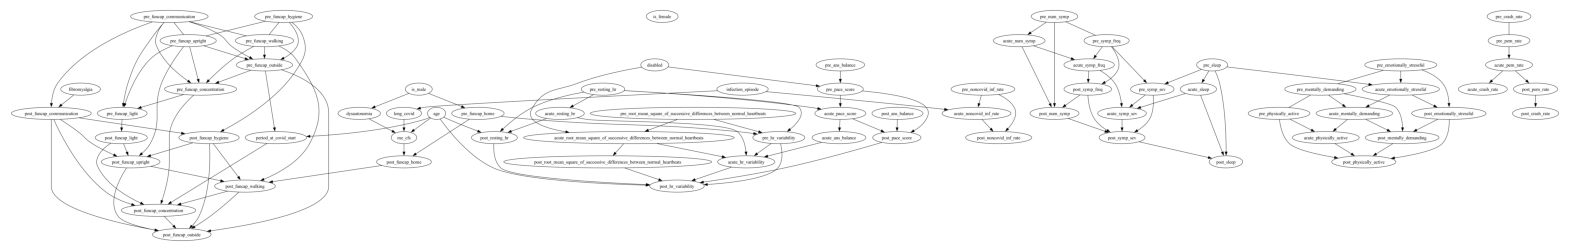

In [ ]:
# Make sure your data is a NumPy array and convert to float (ensures compatibility with np.isnan, np.isinf, etc.)
data_array = final_df_clean.to_numpy().astype(float)

pc_output = pc(
    data_array,
    indep_test_func=kci,
    alpha=0.075, # change to 0.05 if more strict is necessary
    node_names=var_names,
    background_knowledge=bk
)

# Convert to pydot graph
pydot_graph = GraphUtils.to_pydot(pc_output.G, labels=var_names, dpi=250)

# Save and display
pydot_graph.write_png("causal_graph.png")
pydot_graph.write_pdf("causal_graph.pdf")

# Show image
img = Image.open("causal_graph.png")
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

In [140]:
for edge in bk.forbidden_rules_specs:
    if 'acute_num_symp' in (edge[0].get_name(), edge[1].get_name()):
        print(edge[0].get_name(), "-->", edge[1].get_name())

acute_num_symp --> disabled
acute_num_symp --> me_cfs
acute_num_symp --> pre_funcap_home
post_noncovid_inf_rate --> acute_num_symp
post_physically_active --> acute_num_symp
acute_num_symp --> pre_emotionally_stressful
post_hr_variability --> acute_num_symp
post_symp_freq --> acute_num_symp
post_funcap_home --> acute_num_symp
acute_num_symp --> period_at_covid_start
post_ans_balance --> acute_num_symp
acute_num_symp --> age
acute_num_symp --> pre_funcap_upright
acute_num_symp --> pre_funcap_walking
acute_num_symp --> pre_ans_balance
post_num_symp --> acute_num_symp
post_sleep --> acute_num_symp
acute_num_symp --> pre_funcap_concentration
acute_num_symp --> pre_num_symp
acute_num_symp --> pre_resting_hr
post_funcap_hygiene --> acute_num_symp
acute_num_symp --> dysautonomia
acute_num_symp --> pre_funcap_outside
acute_num_symp --> pre_crash_rate
acute_num_symp --> long_covid
post_funcap_light --> acute_num_symp
acute_num_symp --> pre_pem_rate
acute_num_symp --> pre_symp_freq
post_symp_sev 

In [137]:
print("\nInferred Causal Edges:")
for edge in pc_output.G.get_graph_edges():
    print(edge)


Inferred Causal Edges:
age --> me_cfs
age --> period_at_covid_start
age --> post_hr_variability
age --> post_resting_hr
is_male --> dysautonomia
is_male --> pre_funcap_home
disabled --> pre_pace_score
disabled --> acute_root_mean_square_of_successive_differences_between_normal_heartbeats
long_covid --> me_cfs
infection_episode --> long_covid
dysautonomia --> me_cfs
me_cfs --> post_funcap_home
fibromyalgia --> post_funcap_communication
infection_episode --> acute_noncovid_inf_rate
pre_funcap_outside --> period_at_covid_start
period_at_covid_start --> post_funcap_concentration
acute_num_symp --> post_num_symp
pre_num_symp --> acute_num_symp
acute_num_symp --> acute_symp_freq
pre_num_symp --> post_num_symp
post_num_symp --> post_symp_sev
post_symp_freq --> post_num_symp
pre_num_symp --- pre_symp_freq
acute_symp_sev --> post_symp_sev
pre_symp_sev --> acute_symp_sev
acute_symp_freq --> acute_symp_sev
acute_sleep --> acute_symp_sev
pre_symp_sev --> post_symp_sev
post_symp_freq --> post_symp

In [ ]:
# Calculate the percentage of NAs for each column
high_na_columns = na_percentage[na_percentage > 0.75].index.tolist()
print(na_percentage.sort_values(ascending=False))
print(f"Columns with more than 75% NAs: {high_na_columns}")

health_variable
funcap_communication                                                    0.973311
funcap_walking                                                          0.973311
funcap_upright                                                          0.973311
funcap_outside                                                          0.973311
funcap_light                                                            0.973311
funcap_hygiene                                                          0.973311
funcap_home                                                             0.973311
funcap_concentration                                                    0.973311
breathing_session_minutes                                               0.958595
infection_source                                                        0.896727
period                                                                  0.563361
breathing_respiration_rate                                              0.409081
socially_dem

In [ ]:
# Exclude daily health variables with high NA rates
# Drop breathing_session_minutes and breathing_respiration_rate as they have high NA rates
features_to_drop = ['breathing_session_minutes', 'breathing_respiration_rate']
model_df_feat = model_df_sorted[~model_df_sorted['health_variable'].isin(features_to_drop)].copy()

print(f"After dropping high-NA health variables:")
print(f" - # of participants: {model_df_feat['user_id_pk'].nunique()}")
print(f" - # of entries: {len(model_df_feat)}")
print(f" - # of unique user-date-variable entries: {model_df_feat[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")
print(f" - # of unique user-infection entries: {model_df_feat[['user_id_pk', 'infection_episode']].drop_duplicates().shape[0]}")

model_df_feat.head(2)

After filtering for valid infection episodes:
 - # of participants: 646
 - # of entries: 2966855
 - # of unique user-date-variable entries: 2966855
 - # of unique user-infection entries: 653


,user_id_pk,study_enrollment_date,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,age,gender_id,disabled,long_covid,me_cfs,health_variable_name,health_variable_category,health_variable_type,infection_episode,covid_infection_phase,fibromyalgia,dysautonomia,health_variable
0,13,2024-04-22,2,2024-06-25,59.0,2.0,56,2,0,1,0,ans_balance,Insight,Biometric,3.0,pre_infection,0,0,ans_balance
1,13,2024-04-22,2,2024-06-25,35.0,3.0,56,2,0,1,0,blurred_vision,Sensory,Symptom,3.0,pre_infection,0,0,blurred_vision


In [ ]:
# Columns to impute
columns_to_fill_na = ['pre_ans_balance', 'pre_hr_variability', 'pre_pace_score', 'pre_resting_hr', 'pre_root_mean_square_of_successive_differences_between_normal_heartbeats', 'pre_sleep', 
                      'pre_emotionally_stressful', 'pre_mentally_demanding', 'pre_physically_active', 'pre_socially_demanding', 
                      'pre_funcap_communication', 'pre_funcap_concentration', 'pre_funcap_home', 'pre_funcap_hygiene', 'pre_funcap_light', 'pre_funcap_outside', 'pre_funcap_upright', 
                      'pre_funcap_walking']

# Mapping of column to health variable name
col_to_var = {col: "_".join(col.split('_')[1:]) for col in columns_to_fill_na}

# Make sure infection_info_df has datetime
infection_df_clean['observation_date_pk'] = pd.to_datetime(infection_df_clean['observation_date_pk'])

# Convert combined_df dates
combined_df['observation_date_pk'] = pd.to_datetime(combined_df['observation_date_pk'])

# Add health_variable column to combined_df
combined_df = combined_df.merge(model_df_feat[['health_variable_name', 'health_variable']].drop_duplicates(), how='left', on=['health_variable_name'])

# Define a function to impute one row at a time
def impute_pre_value(row, col, health_var):
    if not pd.isna(row[col]):
        return row[col]
    
    uid = row['user_id_pk']
    episode = row['infection_episode']
    
    # Find the start date of this infection episode
    phase_rows = infection_df_clean[
        (infection_df_clean['user_id_pk'] == uid) &
        (infection_df_clean['infection_episode'] == episode)
    ]
    
    if phase_rows.empty:
        return np.nan

    # Take the earliest date in the episode as start
    episode_start = phase_rows['observation_date_pk'].min()
    
    # Look at data before this date for the same user and variable
    subset = combined_df[
        (combined_df['user_id_pk'] == uid) &
        (combined_df['observation_date_pk'] < episode_start) &
        (combined_df['health_variable'] == health_var)
    ]
    
    if subset.empty:
        return np.nan

    return subset['observation_value'].mean()

# Apply imputation
for col in tqdm(columns_to_fill_na):
    health_var = col_to_var[col]
    final_df_imputed[col] = final_df_imputed.apply(
        lambda row: impute_pre_value(row, col, health_var), axis=1
    )

  0%|          | 0/18 [00:00<?, ?it/s]

ans_balance {'pre_ans_balance': 'ans_balance', 'pre_hr_variability': 'hr_variability', 'pre_pace_score': 'pace_score', 'pre_resting_hr': 'resting_hr', 'pre_root_mean_square_of_successive_differences_between_normal_heartbeats': 'root_mean_square_of_successive_differences_between_normal_heartbeats', 'pre_sleep': 'sleep', 'pre_emotionally_stressful': 'emotionally_stressful', 'pre_mentally_demanding': 'mentally_demanding', 'pre_physically_active': 'physically_active', 'pre_socially_demanding': 'socially_demanding', 'pre_funcap_communication': 'funcap_communication', 'pre_funcap_concentration': 'funcap_concentration', 'pre_funcap_home': 'funcap_home', 'pre_funcap_hygiene': 'funcap_hygiene', 'pre_funcap_light': 'funcap_light', 'pre_funcap_outside': 'funcap_outside', 'pre_funcap_upright': 'funcap_upright', 'pre_funcap_walking': 'funcap_walking'} pre_ans_balance


 22%|██▏       | 4/18 [00:03<00:08,  1.72it/s]

hr_variability {'pre_ans_balance': 'ans_balance', 'pre_hr_variability': 'hr_variability', 'pre_pace_score': 'pace_score', 'pre_resting_hr': 'resting_hr', 'pre_root_mean_square_of_successive_differences_between_normal_heartbeats': 'root_mean_square_of_successive_differences_between_normal_heartbeats', 'pre_sleep': 'sleep', 'pre_emotionally_stressful': 'emotionally_stressful', 'pre_mentally_demanding': 'mentally_demanding', 'pre_physically_active': 'physically_active', 'pre_socially_demanding': 'socially_demanding', 'pre_funcap_communication': 'funcap_communication', 'pre_funcap_concentration': 'funcap_concentration', 'pre_funcap_home': 'funcap_home', 'pre_funcap_hygiene': 'funcap_hygiene', 'pre_funcap_light': 'funcap_light', 'pre_funcap_outside': 'funcap_outside', 'pre_funcap_upright': 'funcap_upright', 'pre_funcap_walking': 'funcap_walking'} pre_hr_variability
pace_score {'pre_ans_balance': 'ans_balance', 'pre_hr_variability': 'hr_variability', 'pre_pace_score': 'pace_score', 'pre_rest

 39%|███▉      | 7/18 [01:48<03:30, 19.14s/it]

mentally_demanding {'pre_ans_balance': 'ans_balance', 'pre_hr_variability': 'hr_variability', 'pre_pace_score': 'pace_score', 'pre_resting_hr': 'resting_hr', 'pre_root_mean_square_of_successive_differences_between_normal_heartbeats': 'root_mean_square_of_successive_differences_between_normal_heartbeats', 'pre_sleep': 'sleep', 'pre_emotionally_stressful': 'emotionally_stressful', 'pre_mentally_demanding': 'mentally_demanding', 'pre_physically_active': 'physically_active', 'pre_socially_demanding': 'socially_demanding', 'pre_funcap_communication': 'funcap_communication', 'pre_funcap_concentration': 'funcap_concentration', 'pre_funcap_home': 'funcap_home', 'pre_funcap_hygiene': 'funcap_hygiene', 'pre_funcap_light': 'funcap_light', 'pre_funcap_outside': 'funcap_outside', 'pre_funcap_upright': 'funcap_upright', 'pre_funcap_walking': 'funcap_walking'} pre_mentally_demanding


 44%|████▍     | 8/18 [02:17<03:31, 21.16s/it]

physically_active {'pre_ans_balance': 'ans_balance', 'pre_hr_variability': 'hr_variability', 'pre_pace_score': 'pace_score', 'pre_resting_hr': 'resting_hr', 'pre_root_mean_square_of_successive_differences_between_normal_heartbeats': 'root_mean_square_of_successive_differences_between_normal_heartbeats', 'pre_sleep': 'sleep', 'pre_emotionally_stressful': 'emotionally_stressful', 'pre_mentally_demanding': 'mentally_demanding', 'pre_physically_active': 'physically_active', 'pre_socially_demanding': 'socially_demanding', 'pre_funcap_communication': 'funcap_communication', 'pre_funcap_concentration': 'funcap_concentration', 'pre_funcap_home': 'funcap_home', 'pre_funcap_hygiene': 'funcap_hygiene', 'pre_funcap_light': 'funcap_light', 'pre_funcap_outside': 'funcap_outside', 'pre_funcap_upright': 'funcap_upright', 'pre_funcap_walking': 'funcap_walking'} pre_physically_active


 50%|█████     | 9/18 [02:25<02:43, 18.19s/it]

socially_demanding {'pre_ans_balance': 'ans_balance', 'pre_hr_variability': 'hr_variability', 'pre_pace_score': 'pace_score', 'pre_resting_hr': 'resting_hr', 'pre_root_mean_square_of_successive_differences_between_normal_heartbeats': 'root_mean_square_of_successive_differences_between_normal_heartbeats', 'pre_sleep': 'sleep', 'pre_emotionally_stressful': 'emotionally_stressful', 'pre_mentally_demanding': 'mentally_demanding', 'pre_physically_active': 'physically_active', 'pre_socially_demanding': 'socially_demanding', 'pre_funcap_communication': 'funcap_communication', 'pre_funcap_concentration': 'funcap_concentration', 'pre_funcap_home': 'funcap_home', 'pre_funcap_hygiene': 'funcap_hygiene', 'pre_funcap_light': 'funcap_light', 'pre_funcap_outside': 'funcap_outside', 'pre_funcap_upright': 'funcap_upright', 'pre_funcap_walking': 'funcap_walking'} pre_socially_demanding


 56%|█████▌    | 10/18 [08:19<13:20, 100.02s/it]

funcap_communication {'pre_ans_balance': 'ans_balance', 'pre_hr_variability': 'hr_variability', 'pre_pace_score': 'pace_score', 'pre_resting_hr': 'resting_hr', 'pre_root_mean_square_of_successive_differences_between_normal_heartbeats': 'root_mean_square_of_successive_differences_between_normal_heartbeats', 'pre_sleep': 'sleep', 'pre_emotionally_stressful': 'emotionally_stressful', 'pre_mentally_demanding': 'mentally_demanding', 'pre_physically_active': 'physically_active', 'pre_socially_demanding': 'socially_demanding', 'pre_funcap_communication': 'funcap_communication', 'pre_funcap_concentration': 'funcap_concentration', 'pre_funcap_home': 'funcap_home', 'pre_funcap_hygiene': 'funcap_hygiene', 'pre_funcap_light': 'funcap_light', 'pre_funcap_outside': 'funcap_outside', 'pre_funcap_upright': 'funcap_upright', 'pre_funcap_walking': 'funcap_walking'} pre_funcap_communication


 56%|█████▌    | 10/18 [10:28<08:22, 62.83s/it] 


KeyboardInterrupt: 

In [ ]:
# Columns to impute
columns_to_fill_na = ['post_ans_balance', 'post_hr_variability', 'post_pace_score', 'post_resting_hr', 'post_root_mean_square_of_successive_differences_between_normal_heartbeats', 'post_sleep', 
                      'post_emotionally_stressful', 'post_mentally_demanding', 'post_physically_active', 'post_socially_demanding', 
                      'post_funcap_communication', 'post_funcap_concentration', 'post_funcap_home', 'post_funcap_hygiene', 'post_funcap_light', 'post_funcap_outside', 'post_funcap_upright', 
                      'post_funcap_walking']

# Mapping of column to health variable name
col_to_var = {col: "_".join(col.split('_')[1:]) for col in columns_to_fill_na}

# Define a function to impute one row at a time
def impute_post_value(row, col, health_var):
    if not pd.isna(row[col]):
        return row[col]
    
    uid = row['user_id_pk']
    episode = row['infection_episode']
    
    # Find the start date of this infection episode
    phase_rows = infection_df_clean[
        (infection_df_clean['user_id_pk'] == uid) &
        (infection_df_clean['infection_episode'] == episode)
    ]
    
    if phase_rows.empty:
        return np.nan

    # Take the earliest date in the episode as start
    episode_end = phase_rows['observation_date_pk'].max()
    
    # Look at data before this date for the same user and variable
    subset = combined_df[
        (combined_df['user_id_pk'] == uid) &
        (combined_df['observation_date_pk'] > episode_end) &
        (combined_df['health_variable'] == health_var)
    ]
    
    if subset.empty:
        return np.nan

    return subset['observation_value'].mean()

# Apply imputation
for col in tqdm(columns_to_fill_na):
    health_var = col_to_var[col]
    final_df_imputed[col] = final_df_imputed.apply(
        lambda row: impute_post_value(row, col, health_var), axis=1
    )

In [ ]:
def filter_infection_episodes(df, min_days_symp_pre_post=5, min_days_symp_acute=4, min_days_biom_pre_post=4, min_days_biom_acute=3, min_days_exertion_pre_post=5, 
                              min_days_exertion_acute=3):
    """
    Filters infection episodes based on minimum days of data required for each phase.
    
    Parameters:
    - df (DataFrame): DataFrame containing infection episodes with 'user_id_pk', 'observation_date_pk', and 'infection_episode'.
    - min_days_pre (int): Minimum days required in the pre-infection phase.
    - min_days_acute (int): Minimum days required in the acute infection phase.
    - min_days_post (int): Minimum days required in the long-term post-infection phase.
    
    Returns:
    - DataFrame with filtered infection episodes.
    """
    
    # Group by user and infection episode
    grouped = df.groupby(['user_id_pk', 'infection_episode'])
    
    # Filter based on the number of unique observation dates in each phase
    valid_episodes = []
    
    for (user_id, episode), group in grouped:
        pre_infection_symp_dates = group[(group['covid_infection_phase'] == 'pre_infection')&(group['health_variable_type'] == 'Symptom')]['observation_date_pk'].nunique()
        pre_infection_biom_dates = group[(group['covid_infection_phase'] == 'pre_infection')&(group['health_variable_type'] == 'Biometric')]['observation_date_pk'].nunique()
        pre_infection_exert_dates = group[(group['covid_infection_phase'] == 'pre_infection')&(group['health_variable_type'] == 'Exertion')]['observation_date_pk'].nunique()
        pre_infection_sleep_dates = group[(group['covid_infection_phase'] == 'pre_infection')&(group['health_variable_type'] == 'Sleep')]['observation_date_pk'].nunique()
        acute_infection_symp_dates = group[(group['covid_infection_phase'] == 'acute_infection')&(group['health_variable_type'] == 'Symptom')]['observation_date_pk'].nunique()
        acute_infection_biom_dates = group[(group['covid_infection_phase'] == 'acute_infection')&(group['health_variable_type'] == 'Biometric')]['observation_date_pk'].nunique()
        acute_infection_exert_dates = group[(group['covid_infection_phase'] == 'acute_infection')&(group['health_variable_type'] == 'Exertion')]['observation_date_pk'].nunique()
        acute_infection_sleep_dates = group[(group['covid_infection_phase'] == 'acute_infection')&(group['health_variable_type'] == 'Sleep')]['observation_date_pk'].nunique()
        post_infection_symp_dates = group[(group['covid_infection_phase'] == 'post_long_infection')&((group['health_variable_type'] == 'Symptom'))]['observation_date_pk'].nunique()
        post_infection_biom_dates = group[(group['covid_infection_phase'] == 'post_long_infection')&((group['health_variable_type'] == 'Biometric'))]['observation_date_pk'].nunique()
        post_infection_exert_dates = group[(group['covid_infection_phase'] == 'post_long_infection')&(group['health_variable_type'] == 'Exertion')]['observation_date_pk'].nunique()
        post_infection_sleep_dates = group[(group['covid_infection_phase'] == 'post_long_infection')&(group['health_variable_type'] == 'Sleep')]['observation_date_pk'].nunique()

        if (pre_infection_symp_dates >= min_days_symp_pre_post and 
            acute_infection_symp_dates >= min_days_symp_acute and 
            post_infection_symp_dates >= min_days_symp_pre_post and 
            pre_infection_biom_dates >= min_days_biom_pre_post and
            acute_infection_biom_dates >= min_days_biom_acute and 
            post_infection_biom_dates >= min_days_biom_pre_post and
            pre_infection_exert_dates >= min_days_exertion_pre_post and
            acute_infection_exert_dates >= min_days_exertion_acute and
            post_infection_exert_dates >= min_days_exertion_pre_post and
            pre_infection_sleep_dates >= min_days_biom_pre_post and
            acute_infection_sleep_dates >= min_days_biom_acute and
            post_infection_sleep_dates >= min_days_biom_pre_post
            ):
            valid_episodes.append((user_id, episode))
    
    # Create a mask to filter the original DataFrame
    valid_mask = df.set_index(['user_id_pk', 'infection_episode']).index.isin(valid_episodes)
    
    return df[valid_mask].reset_index(drop=True)

In [ ]:
def prepare_metrics(df, target_types, exclude_phase, experience_flag, funcap_flag, metric_type='avg'):

    df = df.copy()

    # Determine filtering column
    target_col = 'health_variable' if experience_flag else 'health_variable_type'

    # Filter early for better performance
    df_filtered = df[
        (df['covid_infection_phase'].isin([p for p in df['covid_infection_phase'].unique() if p not in exclude_phase])) &
        (df[target_col].isin(target_types))
    ]

    if df_filtered.empty:
        return pd.DataFrame()

    if funcap_flag:
        # Keep most recent FUNCAP entry per user, date, and infection
        df_filtered = (
            df_filtered
            .sort_values(['user_id_pk', 'infection_episode', 'observation_date_pk'])
            .drop_duplicates(subset=['user_id_pk', 'health_variable_name'])
        )

    # Map prefix for phase (e.g., pre, acute, post)
    df_filtered['phase_prefix'] = df_filtered['covid_infection_phase'].str.split('_').str[0]

    # Choose aggregation
    agg_func = 'mean' if metric_type == 'avg' else 'sum'

    # Group and pivot all at once (faster)
    grouped = (
        df_filtered
        .groupby(['user_id_pk', 'infection_episode', 'phase_prefix', 'health_variable'])['observation_value']
        .agg(agg_func)
        .reset_index()
    )

    # Create pivoted columns with prefix in place
    grouped['prefixed_variable'] = grouped['phase_prefix'] + '_' + grouped['health_variable']
    pivot = grouped.pivot_table(
        index=['user_id_pk', 'infection_episode'],
        columns='prefixed_variable',
        values='observation_value'
    ).reset_index()

    return pivot

In [ ]:
# Store infection windows as (user_id, date, episode number)
infection_windows = []

# Initialize new dataframe and column
infection_df_phase = infection_df.copy()
infection_df_phase['covid_infection_phase'] = 'baseline'  # default label

# Get infection events (drop missing num_covid_infections)
infection_events = infection_df_phase[
    (infection_df_phase['beg_of_covid_infection'] == 1) & 
    (infection_df_phase['num_covid_infections'].notna())
][['user_id_pk', 'observation_date_pk', 'num_covid_infections']].copy()

infection_events = infection_events.rename(columns={'observation_date_pk': 'infection_start_date'})

# Add infection_id for each episode
infection_events['infection_episode'] = infection_events['num_covid_infections']


for idx, row in infection_events.iterrows():
    user = row['user_id_pk']
    start_date = row['infection_start_date']
    episode = int(row['infection_episode'])

    # Define date windows
    pre_start = start_date - timedelta(days=30) # 30 days before the infection start date is considered the pre-infection period
    acute_end = start_date + timedelta(days=14) # 14 days after the infection start date is considered the acute infection period
    mid_post_end = start_date + timedelta(days=90) # After that, up to 90 days after the infection start date is considered the mid-range post-infection period
    long_post_end = mid_post_end + timedelta(days=30) # From mid post infection start date, for 30 days the person is considered to be in the long-term post-infection period

    # Collect all dates in window (pre to long post)
    for date in pd.date_range(pre_start, long_post_end):
        infection_windows.append((user, date, episode))

    # Apply labels
    mask = (infection_df_phase['user_id_pk'] == user)
    infection_df_phase.loc[mask & (infection_df_phase['observation_date_pk'] >= pre_start) & (infection_df_phase['observation_date_pk'] < start_date
                                                                                              ), 'covid_infection_phase'] = 'pre_infection'
    infection_df_phase.loc[mask & (infection_df_phase['observation_date_pk'] >= start_date) & (infection_df_phase['observation_date_pk'] < acute_end
                                                                                               ), 'covid_infection_phase'] = 'acute_infection'
    infection_df_phase.loc[mask & (infection_df_phase['observation_date_pk'] >= acute_end) & (infection_df_phase['observation_date_pk'] < mid_post_end
                                                                                              ), 'covid_infection_phase'] = 'post_mid_infection'
    infection_df_phase.loc[mask & (infection_df_phase['observation_date_pk'] >= mid_post_end) & (infection_df_phase['observation_date_pk'] < long_post_end
                                                                                                 ), 'covid_infection_phase'] = 'post_long_infection'

window_df = pd.DataFrame(infection_windows, columns=['user_id_pk', 'observation_date_pk', 'infection_episode'])

# Count how many infection episodes overlap on each (user, date)
overlap_counts = (
    window_df
    .groupby(['user_id_pk', 'observation_date_pk'])
    .size()
    .reset_index(name='infection_window_count')
)

# Merge overlap counts back in
window_df = window_df.merge(overlap_counts, on=['user_id_pk', 'observation_date_pk'], how='left')

# Filter to dates where there's overlap (i.e., more than 1 infection episode on the same date)
overlapping_dates = window_df[window_df['infection_window_count'] > 1]

# From these, extract all (user, infection_episode) combinations involved in overlaps
compromised_episodes = overlapping_dates[['user_id_pk', 'infection_episode']].drop_duplicates()
compromised_episodes['is_compromised'] = True

# Prepare your final df with episode numbers
infection_df_final = infection_df_phase.dropna(subset=['num_covid_infections'])
infection_df_final['infection_episode'] = infection_df_final['num_covid_infections']
infection_df_final.loc[infection_df_final['covid_infection_phase'] == 'pre_infection', 'infection_episode'] = (
    infection_df_final['infection_episode'] + 1
)

# Merge in the compromised flag
infection_df_final = infection_df_final.merge(
    compromised_episodes, 
    on=['user_id_pk', 'infection_episode'], 
    how='left'
)

infection_df_final['is_compromised'] = infection_df_final['is_compromised'].fillna(False)

# Keep only valid rows
infection_df_final = infection_df_final[
    (infection_df_final['covid_infection_phase'] != 'baseline') & 
    (~infection_df_final['is_compromised'])
].copy()

# Drop helper columns
infection_df_final.drop(columns=['is_compromised'], inplace=True)

infection_df_final.head(2)

/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_58391/2363866463.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infection_df_final['infection_episode'] = infection_df_final['num_covid_infections']
/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_58391/2363866463.py:80: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  infection_df_final['is_compromised'] = infection_df_final['is_compromised'].fillna(False)


,user_id_pk,observation_date_pk,study_enrollment_date,number_cov_inf_at_enrollment,active_covid_infection,active_other_infection,active_unknown_infection,beg_of_covid_infection,beg_of_other_infection,beg_of_unknown_infection,num_covid_infections,covid_infection_phase,infection_episode
415,13,2024-06-25,2024-04-22,2,0.0,0.0,0.0,0,0,0,2.0,pre_infection,3.0
416,13,2024-06-26,2024-04-22,2,0.0,0.0,0.0,0,0,0,2.0,pre_infection,3.0


In [ ]:
# Select only funcap columns
pre_funcap_cols = [col for col in final_df_imputed.columns if col.startswith('pre_funcap')]
post_funcap_cols = [col for col in final_df_imputed.columns if col.startswith('post_funcap')]

# Combine into a working DataFrame with non-NA rows for fitting
X_funcap = final_df_imputed[pre_funcap_cols + post_funcap_cols]

# Add additional features to help the model predict
X_additional = final_df_imputed[[ 
    'age', 'is_male', 'is_female', 'is_gender_diverse', 'disabled', 'long_covid', 'me_cfs', 'fibromyalgia', 'dysautonomia', 'number_cov_inf_at_enrollment', 'infection_episode',
    'pre_symp_sev', 'post_symp_sev', 'pre_hr_variability', 'post_hr_variability', 
    'pre_resting_hr', 'post_resting_hr', 'pre_physically_active', 'post_physically_active',
    'pre_mentally_demanding', 'post_mentally_demanding'
]]

X_full = pd.concat([X_funcap, X_additional], axis=1)

# Fit imputer
imputer = IterativeImputer(random_state=42, max_iter=10)
X_imputed = imputer.fit_transform(X_full)

# Replace in original DataFrame
X_imputed_df = pd.DataFrame(X_imputed, columns=X_full.columns, index=final_df_imputed.index)

# Only update the funcap columns
for col in pre_funcap_cols + post_funcap_cols:
    final_df_imputed[col] = X_imputed_df[col]

/Users/rachelrobles/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
